# Sea Ice Comparisons to Observations

This script shows how to load and plot sea ice concentration from CICE output and compare it to the NSIDC CDR (National Snow and Ice Data Centre, Climate Data Record) dataset

This notebook uses the _ACCESS-NRI Intake Catalog_ following the examples in [Tutorials/Using the Intake Catalog](https://cosima-recipes.readthedocs.io/en/latest/Tutorials/Using_Intake_Catalog.html). 

Requirements: The runs analysed here are only in access-nri-intake-catalog version 0.1.0 or newer. This is included in `conda/analysis3-23.10` or newer modules from `/g/data/hh5/public/modules`. 

**OM2 Experiments:**

These are the ACCESS-OM2 runs we are going to use, we can compare results from prototype runs forced with ERA5 against normal runs using JRA55do, as [described on the ACCESS_HIVE](https://forum.access-hive.org.au/t/era-5-forced-access-om2-simulations/1103/5). To compare against the observational datasets, we use IAF (Inter-Annual Forcing). _N.B._ The JRA55do runs used here a slightly different to the typical (e.g. _025deg_jra55_iaf_omip2_cycle6_) in the model version used and the timeframes evaluated.

In [77]:
from intake import cat
from datatree import DataTree, map_over_subtree

from dask.distributed import Client
import glob
import xarray as xr
import numpy as np
from datetime import timedelta
import cf_xarray as cfxr
import xesmf

# plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean.cm as cmo
import matplotlib.lines as mlines
import cartopy.feature as cft

# Import my functions
functions_path = os.path.abspath("/home/566/nd0349/access-om3-analysis/functions")
fig_path = os.path.abspath("/home/566/nd0349/access-om3-analysis/figures")
if functions_path not in sys.path:
    sys.path.append(functions_path)
from get_files import *
test()

RUN_DICT = {
    "CICE6 w/ waves": {"expt": "wave-propagation-1deg", "model": "cice6"},
    "ACCESS-OM2-10 IAF OMIP2": {"expt": "1deg_jra55_iaf_omip2_cycle1", "model": "access-om2"},
    # "ACCESS-OM2-10 JRA55-do RYF [dev]": {"expt": "1deg_jra55_ryf-expt-054ea9ee", "model": "access-om2-dev"},
    "ACCESS-OM2-10 IAF [dev]": {"expt": "1deg_jra55_iaf-expt-70159801", "model": "access-om2-dev"},
    # "ACCESS-OM3-10 JRA55-do RYF [dev]": {"expt": "1deg_mom6_cice6_ryf", "model": "access-om3-dev"},
    "ACCESS-OM3-10 IAF [dev]": {"expt": "1deg_mom6_cice6_iaf", "model": "access-om3-dev"},
    # "ACCESS-OM3-025 JRA55-do IAF [dev]": {"expt": "mom6-cice6_ryf_025deg_rel", "model": "access-om3-dev"},
    # "ACCESS-OM3-10-wave JRA55-do IAF [dev]": {"expt": "wav_iaf_rel", "model": "access-om3-wav-dev"},
}

VARS = ["aice_m", "hi_m" ]  # ice area fraction or sea ice concentration, ice thickness averaged by grid cell area
VARS_2D = ["area_t", "geolat_t", "geolon_t"]

Functions from get_files.py imported!


**Observational Data:**

Sea Ice concentration is measured through passive microwave remote sensing. We are going to use the NSIDC CDR Dataset (described at [nsidc.org](https://nsidc.org/data/g02202/versions/4))

In [67]:
OBS_TIME_SLICE = slice("1979", "2022")
sh_obs_url = "https://polarwatch.noaa.gov/erddap/griddap/nsidcG02202v4shmday"
nh_obs_url = "https://polarwatch.noaa.gov/erddap/griddap/nsidcG02202v4nhmday"

**Load depenencies:**

A standard way to calculate climatologies. (We start in 1991 as earlier decades are influenced by model spin-up for 0.25deg runs which only start in 1980.)

In [68]:
CLIMAT_TIME_SLICE = slice("1900", "2020")


def climatology(ds):
    return ds.sel(time=CLIMAT_TIME_SLICE).groupby("time.month").mean("time")

Start a dask client

In [69]:
client = Client(threads_per_worker=1,memory_limit=0)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41693 instead
  warnings.warn(


In [70]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/41693/status,
Dashboard: /proxy/41693/status,Workers: 14
Total threads: 14,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39779,Workers: 14
Dashboard: /proxy/41693/status,Total threads: 14
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:36013,Total threads: 1
Dashboard: /proxy/45355/status,Memory: 0 B
Nanny: tcp://127.0.0.1:42675,


Open the _ACCESS-NRI Intake Catalog_

In [6]:
catalog = cat.access_nri

# Load the ACCESS-OM2 results

For CICE data in OM2, we need to do some wrangling to make it easier to deal with. This is described in more detail in [DocumentedExamples/SeaIce_Plot_Example](https://cosima-recipes.readthedocs.io/en/latest/DocumentedExamples/SeaIce_Plot_Example.html). Its included in this function:

In [78]:

def open_by_experiment(exp_name, vars, VARS_2D, RUN_DICT, catalog):
    """Concatenate any datasets provided for this experiment into one ds, and add area and geo coordinates"""

    print(f"Loading... {exp_name}")

    if RUN_DICT[exp_name]["model"] in ["cice6"]:
        import socket

        def get_path(experiments):
            hostname = socket.gethostname()
            if "gadi" in hostname:
                machine = "gadi"
                #path = "/g/data/ps29/nd0349/runs/cice6/"
                path = "/scratch/ps29/nd0349/CICE_RUNS/"
                fig_path = "/home/566/nd0349/access-om3-analysis/figures/"
            elif "setonix" in hostname:
                machine = "setonix"
            else:
                machine = "noahday"
                path = "/Users/noahday/GitHub/cice-dev/cice-dirs/runs/"
                fig_path = "/Users/noahday/GitHub/access-om3-analysis/figures/"
        
            print(f"Running on {machine}")
                
            return path, fig_path
        
        
        experiment_sets = {
            "test": ["sandbox"], #["baseline-1deg", "nofsd-1deg", "wave-profile-1deg"], # "sandbox", "test"
            "gx3": ["baseline-gx3", "wave-constant-gx3", "wave-profile-gx3", "wave-random-gx3"],
            "baseline": ["baseline-1deg", "baseline-025deg"],
            "wave-1deg": ["nofsd-1deg"], # "wave-profile-1deg", "wave-random-1deg" , "nofsd-1deg"
            "temp": ["baseline-1deg", "wave-profile-1deg", "wave-propagation-1deg"],
        }
        expt = "wave-propagation-1deg"
        expt_path, fig_path = get_path(expt)
        
        histfreq = "d"
        path = os.path.join(expt_path, expt, "history/")
        if histfreq == "h":
            file_pattern = os.path.join(path, "iceh_01h.????-??-??-?????.nc")
            time_delta = timedelta(minutes=30)
        elif histfreq == "d":
            file_pattern = os.path.join(path, "iceh.????-??-??.nc")
            time_delta = timedelta(hours=12)
        elif histfreq == "m":
            file_pattern = os.path.join(path, "iceh.????-??.nc")  # Adjust this if needed
            time_delta = timedelta(days=16)
        files = sorted(glob.glob(file_pattern))
        
        basic_ice_vars = ["aice", "hi", "iage", "fsdrad"]
        ocn_forcing_vars = ["sst", "sss", "uocn", "vocn"]
        wave_forcing_vars = ["wave_sig_ht"] # peak period? MWD?
        
        VARS = basic_ice_vars + ocn_forcing_vars + wave_forcing_vars
        VARS_with_m = VARS + [var + "_m" for var in VARS]
        VARS = VARS + VARS_with_m
        keep_vars = ["TLAT", "TLON", "time", "tarea", "NFSD", "NCAT"] + VARS
        
        sample_ds = xr.open_dataset(files[0])
        drop_vars = [var for var in sample_ds.variables if var not in keep_vars]
            
        cice_ds = xr.open_mfdataset(
                files,
                combine="by_coords",
                use_cftime=True,      # ensures all times use cftime objects
                drop_variables=drop_vars,
                decode_times=True,
            )
        cice_ds = cice_ds.rename(({"ni": "xt_ocean", "nj": "yt_ocean"}))

        cice_ds['aice_m'] = cice_ds['aice']
        area_ds = xr.open_mfdataset("/g/data/vk83/configurations/inputs/access-om3/cice/grids/global.1deg/2024.05.14/grid.nc", 
                                    combine="by_coords")
        area_ds = area_ds.rename(({"ni": "xt_ocean", 
                                   "nj": "yt_ocean", 
                                   "tarea": "area_t", 
                                   "tlat": "geolat_t", 
                                   "tlon": "geolon_t"})
                                )
        # VARS_2D = ["area_t", "geolat_t", "geolon_t"]
        
        # Label the lats and lons
        cice_ds.coords["ni"] = area_ds["xt_ocean"].values
        cice_ds.coords["nj"] = area_ds["yt_ocean"].values
        
        # Copy attributes for cf compliance
        cice_ds.ni.attrs = area_ds.xt_ocean.attrs
        cice_ds.nj.attrs = area_ds.yt_ocean.attrs
        
        cice_ds = cice_ds.rename(({"ni": "xt_ocean", "nj": "yt_ocean"}))
        
        # Add the geolon, geolat, and area as extra co-ordinates fields from area_t
        
        cice_ds = cice_ds.assign_coords(
            {
                "geolat_t": area_ds.geolat_t,
                "geolon_t": area_ds.geolon_t,
                "area_t": area_ds.area_t,
            }
        )

    
    elif RUN_DICT[exp_name]["model"] in ["access-om2", "access-om3"]:
        # If the experiment is in the Catalog then get the data from there
        # get the data for each run of this config
        cice_ds = xr.concat(
            [open_by_name(iName, vars, catalog) for iName in [RUN_DICT[exp_name]['expt']]], dim="time"
        )
    
        # We also want the area/lat/lon fields, but these are not time dependent.
        area_ds = xr.merge(
            [
                xr.open_dataset(
                    catalog[RUN_DICT[exp_name]['expt']]
                    .search(variable=iVar)
                    .df.path[0]
                    # path of the first file with the area field, the geolon field and the geolat field
                ).drop_vars("time")
                for iVar in VARS_2D
            ]
        )
    
        # Label the lats and lons
        cice_ds.coords["ni"] = area_ds["xt_ocean"].values
        cice_ds.coords["nj"] = area_ds["yt_ocean"].values
    
        # Copy attributes for cf compliance
        cice_ds.ni.attrs = area_ds.xt_ocean.attrs
        cice_ds.nj.attrs = area_ds.yt_ocean.attrs
    
        cice_ds = cice_ds.rename(({"ni": "xt_ocean", "nj": "yt_ocean"}))
    
        # Add the geolon, geolat, and area as extra co-ordinates fields from area_t
    
        cice_ds = cice_ds.assign_coords(
            {
                "geolat_t": area_ds.geolat_t,
                "geolon_t": area_ds.geolon_t,
                "area_t": area_ds.area_t,
            }
        )
    
        # cice timestamps are also misleading:
        cice_ds["time"] = cice_ds.time.to_pandas() - timedelta(minutes=1)

    
    elif RUN_DICT[exp_name]["model"] == "access-om2-dev":
        # Else, it is a development expt and stored on ps29
        base_dir = f"/g/data/ps29/nd0349/runs/{exp_name[0:10].lower()}/archive/{RUN_DICT[exp_name]['expt']}/"
        output_dirs = glob.glob(os.path.join(base_dir, "output[0-9][0-9][0-9]"))
        
        # Extract most recent simulation
        if output_dirs:
            output_number = max(int(d[-3:]) for d in output_dirs)  # Extract last 3 digits
            output_number = f"{output_number:03d}"  # Ensure it stays in 000 format
        else:
            output_number = "000"  # Default if no directories exist

        most_recent_file = False
        if most_recent_file:
            print(f"Output folder: {output_number}")
            files = sorted(glob.glob(file_pattern))
        else:
            all_files = []
            for output_dir in output_dirs:
                file_pattern = os.path.join(output_dir, "ice/OUTPUT/", "iceh.????-??.nc")
                all_files.extend(glob.glob(file_pattern))
            files = sorted(all_files)
            
        # files = files[:360]
        # print(files)
        # path = os.path.join(base_dir, f"output{output_number}", "ice/OUTPUT/")
        # file_pattern = os.path.join(path, "iceh.????-??.nc")
        # files = sorted(glob.glob(file_pattern))
        # file_list = sorted(glob.glob(file_pattern))
        # print(file_pattern)
        # print(files)
        sample_ds = xr.open_mfdataset(files[0],combine="by_coords")

        # List of variables to keep
        keep_vars = ["TLAT", "TLON", "time"] + vars
        
        drop_vars = [var for var in sample_ds.variables if var not in keep_vars]
        
        cice_ds = xr.open_mfdataset(
            files, 
            combine="by_coords", 
            decode_timedelta=False,
            drop_variables=drop_vars  # Now using the correct list
        )
        
        # We also want the area/lat/lon fields, but these are not time dependent.
        area_ds = xr.open_mfdataset("/g/data/vk83/configurations/inputs/access-om3/cice/grids/global.1deg/2024.05.14/grid.nc", 
                                    combine="by_coords")
        area_ds = area_ds.rename(({"ni": "xt_ocean", "nj": "yt_ocean", "tarea": "area_t", "tlat": "geolat_t", "tlon": "geolon_t"}))
        # VARS_2D = ["area_t", "geolat_t", "geolon_t"]
        # VARS_2D = ["area_t", "geolat_t", "geolon_t"]
        
        # Label the lats and lons
        cice_ds.coords["ni"] = area_ds["xt_ocean"].values
        cice_ds.coords["nj"] = area_ds["yt_ocean"].values
        
        # Copy attributes for cf compliance
        cice_ds.ni.attrs = area_ds.xt_ocean.attrs
        cice_ds.nj.attrs = area_ds.yt_ocean.attrs
        
        cice_ds = cice_ds.rename(({"ni": "xt_ocean", "nj": "yt_ocean"}))
        
        # Add the geolon, geolat, and area as extra co-ordinates fields from area_t
        
        cice_ds = cice_ds.assign_coords(
            {
                "geolat_t": area_ds.geolat_t,
                "geolon_t": area_ds.geolon_t,
                "area_t": area_ds.area_t,
            }
        )
        
        # cice timestamps are also misleading:
        cice_ds["time"] = cice_ds.time.to_pandas() - timedelta(minutes=1)


    
    elif RUN_DICT[exp_name]["model"] == "access-om3-dev":
        # Else, it is a development expt and stored on ps29
        most_recent_file = False
        run_status = 'archive' # 'archive' or 'work'
        if run_status == 'work':
            print("Using work directory")
            base_dir = f"/scratch/ps29/nd0349/{exp_name[0:10].lower()}/work/{RUN_DICT[exp_name]['expt']}/"
            file_pattern = os.path.join(base_dir, "access-om3.cice.1mon.mean.????-??.nc")
        else:
        
            base_dir = f"/g/data/ps29/nd0349/runs/{exp_name[0:10].lower()}/archive/{RUN_DICT[exp_name]['expt']}/"
            # base_dir = f" /g/data/ps29/nd0349/access-om2/archive/{exp_name[0:10].lower()}/archive/{RUN_DICT[exp_name]['expt']}/"
           
            output_dirs = glob.glob(os.path.join(base_dir, "output[0-9][0-9][0-9]"))
        
            # Extract most recent simulation
            if output_dirs:
                output_number = max(int(d[-3:]) for d in output_dirs)  # Extract last 3 digits
                output_number = f"{output_number:03d}"  # Ensure it stays in 000 format
            else:
                output_number = "000"  # Default if no directories exist
            
            file_pattern = os.path.join(base_dir, f"output{output_number}", "access-om3.cice.1mon.mean.????-??.nc")

        if most_recent_file:
            print(f"Output folder: {output_number}")
            files = sorted(glob.glob(file_pattern))
        else:
            all_files = []
            for output_dir in output_dirs:
                file_pattern = os.path.join(output_dir, "access-om3.cice.1mon.mean.????-??.nc")
                all_files.extend(glob.glob(file_pattern))
            files = sorted(all_files)
        
        # files = files[:360]
        print(files)
        
        sample_ds = xr.open_mfdataset(files[0],combine="by_coords")

        # List of variables to keep
        keep_vars = ["TLAT", "TLON", "time"] + vars
        
        drop_vars = [var for var in sample_ds.variables if var not in keep_vars]
        
        cice_ds = xr.open_mfdataset(
            files, 
            chunks={'ni':-1,'nj':-1,'time':120},
            combine="by_coords", 
            decode_timedelta=False,
            drop_variables=drop_vars  # Now using the correct list
        )
        
        # We also want the area/lat/lon fields, but these are not time dependent.
        area_ds = xr.open_mfdataset("/g/data/vk83/configurations/inputs/access-om3/cice/grids/global.1deg/2024.05.14/grid.nc",
                                    drop_variables=["ulat","ulon"],
                                    combine="by_coords")
        area_ds = area_ds.rename(({"ni": "xt_ocean", "nj": "yt_ocean", "tarea": "area_t", "tlat": "geolat_t", "tlon": "geolon_t"}))
        # VARS_2D = ["area_t", "geolat_t", "geolon_t"]
        # VARS_2D = ["area_t", "geolat_t", "geolon_t"]

        def radians_to_degrees(da):
            return da * (180 / np.pi)
        
        # Apply conversion efficiently while handling Dask arrays
        area_ds = area_ds.assign_coords(
            geolat_t=xr.apply_ufunc(radians_to_degrees, area_ds.geolat_t, dask="parallelized"),
            geolon_t=xr.apply_ufunc(radians_to_degrees, area_ds.geolon_t, dask="parallelized")
        )

        
        # Label the lats and lons
        cice_ds.coords["ni"] = area_ds["xt_ocean"].values
        cice_ds.coords["nj"] = area_ds["yt_ocean"].values
        
# plt.pcolormesh(all_data[1].geolon_t, all_data[1].geolat_t, all_data[1], shading='auto')

        
        # Copy attributes for cf compliance
        cice_ds.ni.attrs = area_ds.xt_ocean.attrs
        cice_ds.nj.attrs = area_ds.yt_ocean.attrs
        
        cice_ds = cice_ds.rename(({"ni": "xt_ocean", "nj": "yt_ocean"}))
        
        # Add the geolon, geolat, and area as extra co-ordinates fields from area_t
        
        cice_ds = cice_ds.assign_coords(
            {
                "geolat_t": area_ds.geolat_t,
                "geolon_t": area_ds.geolon_t,
                "area_t": area_ds.area_t,
            }
        )


        
        # cice timestamps are also misleading:
        # cice_ds["time"] = cice_ds.time.to_pandas() - timedelta(minutes=1)

    elif RUN_DICT[exp_name]["model"] == "access-om3-wav-dev":
        # ACCESS-OM3 development
        base_dir = f"/scratch/ps29/nd0349/{exp_name[0:10].lower()}/archive/{RUN_DICT[exp_name]['expt']}/"
        output_dirs = glob.glob(os.path.join(base_dir, "output[0-9][0-9][0-9]"))
        
        # # Extract most recent simulation
        # if output_dirs:
        #     output_number = max(int(d[-3:]) for d in output_dirs)  # Extract last 3 digits
        #     output_number = f"{output_number:03d}"  # Ensure it stays in 000 format
        # else:
        #     output_number = "000"  # Default if no directories exist
        
        # path = os.path.join(base_dir, f"output{output_number}")
        # file_pattern = os.path.join(path, "access-om3.cice.*.nc")
        # files = sorted(glob.glob(file_pattern))
        # file_list = sorted(glob.glob(file_pattern))

        file_pattern = os.path.join(base_dir, "output[0-9][0-9][0-9]", "access-om3.cice.*.nc")
        file_list = sorted(glob.glob(file_pattern))
        # print(file_list)
        # Read in data
        if file_list:
            cice_ds = xr.open_mfdataset(file_list, combine="by_coords")
        else:
            print("No matching files found.")


        # Read in data
        cice_ds = xr.open_mfdataset(file_list, combine="by_coords")
        # cice_ds['aice_m'] = cice_ds['aice'].resample(time='ME').max()
        cice_ds['aice_m'] = cice_ds['aice']
        area_ds = xr.open_mfdataset("/g/data/vk83/configurations/inputs/access-om3/cice/grids/global.1deg/2024.05.14/grid.nc", 
                                    combine="by_coords")
        area_ds = area_ds.rename(({"ni": "xt_ocean", 
                                   "nj": "yt_ocean", 
                                   "tarea": "area_t", 
                                   "tlat": "geolat_t", 
                                   "tlon": "geolon_t"})
                                )
        # VARS_2D = ["area_t", "geolat_t", "geolon_t"]
        
        # Label the lats and lons
        cice_ds.coords["ni"] = area_ds["xt_ocean"].values
        cice_ds.coords["nj"] = area_ds["yt_ocean"].values
        
        # Copy attributes for cf compliance
        cice_ds.ni.attrs = area_ds.xt_ocean.attrs
        cice_ds.nj.attrs = area_ds.yt_ocean.attrs
        
        cice_ds = cice_ds.rename(({"ni": "xt_ocean", "nj": "yt_ocean"}))
        
        # Add the geolon, geolat, and area as extra co-ordinates fields from area_t
        
        cice_ds = cice_ds.assign_coords(
            {
                "geolat_t": area_ds.geolat_t,
                "geolon_t": area_ds.geolon_t,
                "area_t": area_ds.area_t,
            }
        )
        
        # cice timestamps are also misleading:
        cice_ds["time"] = cice_ds.time.to_pandas() - timedelta(minutes=1)
    print(f"{exp_name} loaded.")
    return cice_ds

In [79]:
# si_dt['ACCESS-OM2-10 JRA55-do IAF [dev]']

In [80]:
%%time

si_name_ds_pairs = [(iRun, open_by_experiment(iRun, VARS, VARS_2D, RUN_DICT, catalog)) for iRun in RUN_DICT.keys()]

si_dt = DataTree.from_dict(dict(si_name_ds_pairs))

Loading... CICE6 w/ waves
Running on gadi
CICE6 w/ waves loaded.
Loading... ACCESS-OM2-10 IAF OMIP2
ACCESS-OM2-10 IAF OMIP2 loaded.
Loading... ACCESS-OM2-10 IAF [dev]
ACCESS-OM2-10 IAF [dev] loaded.
Loading... ACCESS-OM3-10 IAF [dev]
['/g/data/ps29/nd0349/runs/access-om3/archive/1deg_mom6_cice6_iaf/output000/access-om3.cice.1mon.mean.1958-01.nc', '/g/data/ps29/nd0349/runs/access-om3/archive/1deg_mom6_cice6_iaf/output000/access-om3.cice.1mon.mean.1958-02.nc', '/g/data/ps29/nd0349/runs/access-om3/archive/1deg_mom6_cice6_iaf/output000/access-om3.cice.1mon.mean.1958-03.nc', '/g/data/ps29/nd0349/runs/access-om3/archive/1deg_mom6_cice6_iaf/output000/access-om3.cice.1mon.mean.1958-04.nc', '/g/data/ps29/nd0349/runs/access-om3/archive/1deg_mom6_cice6_iaf/output000/access-om3.cice.1mon.mean.1958-05.nc', '/g/data/ps29/nd0349/runs/access-om3/archive/1deg_mom6_cice6_iaf/output000/access-om3.cice.1mon.mean.1958-06.nc', '/g/data/ps29/nd0349/runs/access-om3/archive/1deg_mom6_cice6_iaf/output000/access

In [59]:
# si_dt.to_netcdf("/home/566/nd0349/access-om3-analysis/data/sic_dt.nc")

In [60]:
# from datatree import DataTree

# si_dt = DataTree.open_dataset("/home/566/nd0349/access-om3-analysis/data/sic_dt.nc")

In [82]:
si_dt['ACCESS-OM3-10 IAF [dev]'].ds.chunk({'time':120})

<xarray.Dataset> Size: 397MB
Dimensions:   (time: 228, yt_ocean: 300, xt_ocean: 360)
Coordinates:
  * time      (time) datetime64[ns] 2kB 1958-01-16T12:00:00 ... 1976-12-16T12...
  * xt_ocean  (xt_ocean) int64 3kB 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
  * yt_ocean  (yt_ocean) int64 2kB 0 1 2 3 4 5 6 ... 293 294 295 296 297 298 299
    geolat_t  (yt_ocean, xt_ocean) float64 864kB dask.array<chunksize=(300, 360), meta=np.ndarray>
    geolon_t  (yt_ocean, xt_ocean) float64 864kB dask.array<chunksize=(300, 360), meta=np.ndarray>
    area_t    (yt_ocean, xt_ocean) float64 864kB dask.array<chunksize=(300, 360), meta=np.ndarray>
Data variables:
    hi_m      (time, yt_ocean, xt_ocean) float64 197MB dask.array<chunksize=(120, 300, 360), meta=np.ndarray>
    aice_m    (time, yt_ocean, xt_ocean) float64 197MB dask.array<chunksize=(120, 300, 360), meta=np.ndarray>
Attributes:
    title:               access-om3
    contents:            Diagnostic and Prognostic Variables
    source:              CICE Sea Ice Model, unknown_version_name
    comment:             This year has 365 days
    comment2:            File written on model date 19580201
    comment3:            seconds elapsed into model date:      0
    time_period_freq:    month_1
    time_axis_position:  middle
    conventions:         CF-1.0
    history:             This dataset was created on 2025-03-18 at 20:28
    io_flavor:           io_pio2 hdf5

## Make a quick animation

In [ ]:
from io import BytesIO
# import xarray as xr
import matplotlib

matplotlib.use("Agg")
import imageio.v3 as iio


def process(ds_sel, time):
    fig, ax = plt.subplots()
    ds_sel["aice_m"].plot(ax=ax, x="geolon_t", y="geolat_t", vmin=0, vmax=1, cmap=cmo.ice) # x="geolon_t", y="geolat_t", 
    with BytesIO() as buf:
        fig.savefig(buf, format="png")
        plt.close(fig)
        image = iio.imread(buf.getvalue())
    return image



In [130]:
%%time
expt = list(RUN_DICT.keys())[0]
month = 2 # 1 = January 


expt_name = RUN_DICT[expt]['expt']
model_name = RUN_DICT[expt]['model']
southern_ocean_mask = (si_dt[expt].geolat_t < -30).compute()
ds = si_dt[expt].where(southern_ocean_mask, drop=True).isel(time=slice(month-1,-1,12)).copy() 
ds = ds.chunk({"time": 1, "xt_ocean": -1, "yt_ocean": -1})

futures = [
    client.submit(process, ds.sel(time=time), time) for time in ds["time"].values
]
expt_name = RUN_DICT[expt]['expt']
with iio.imopen(os.path.join(fig_path, f"ice_concentration_{expt_name}.gif"), "w", extension=".gif") as f:
    for future in futures:
        image = future.result()
        f.write(image)

2025-05-28 11:22:56,684 - distributed.worker - WARNING - Compute Failed
Key:       process-f58749910623481ee56dfdd0cdbeeaea
State:     long-running
Function:  process
args:      (DataTree('ACCESS-OM2-10 JRA55-do IAF [dev]', parent=None)
    Dimensions:   (yt_ocean: 0, xt_ocean: 0)
    Coordinates:
        time      datetime64[ns] 8B 1958-02-28T23:59:00
        TLON      (yt_ocean, xt_ocean) float32 0B dask.array<chunksize=(0, 0), meta=np.ndarray>
        TLAT      (yt_ocean, xt_ocean) float32 0B dask.array<chunksize=(0, 0), meta=np.ndarray>
      * xt_ocean  (xt_ocean) int64 0B 
      * yt_ocean  (yt_ocean) int64 0B 
        ulat      (yt_ocean, xt_ocean) float64 0B dask.array<chunksize=(0, 0), meta=np.ndarray>
        ulon      (yt_ocean, xt_ocean) float64 0B dask.array<chunksize=(0, 0), meta=np.ndarray>
        geolat_t  (yt_ocean, xt_ocean) float64 0B dask.array<chunksize=(0, 0), meta=np.ndarray>
        geolon_t  (yt_ocean, xt_ocean) float64 0B dask.array<chunksize=(0, 0), meta=np.

TypeError: No numeric data to plot.

In [131]:
def fancier_plot(ds_sel, time):
    fig, ax = plt.subplots(
                         subplot_kw={'projection': ccrs.SouthPolarStereo(true_scale_latitude=-70)},
                         gridspec_kw={'wspace': 0.1, 'hspace': 0.15})  # Adjust spacing

    # Add coastlines and land features
    land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                       edgecolor='black',
                                       facecolor='gray', linewidth=0.5)

    ax.set_global()
    ax.coastlines(resolution='50m')
    ax.add_feature(land_50m)
    ax.set_extent([-180, 180, -90, -45], crs=ccrs.PlateCarree())

    ds_sel["aice_m"].plot(ax=ax, x="geolon_t", y="geolat_t", vmin=0, vmax=1, cmap=cmo.ice, transform=ccrs.PlateCarree()) # x="geolon_t", y="geolat_t", 
    with BytesIO() as buf:
        fig.savefig(buf, format="png")
        plt.close(fig)
        image = iio.imread(buf.getvalue())
    return image

In [ ]:
import calendar
expt = list(RUN_DICT.keys())[0]
month = 2 # 1 = January 

import cftime

# Extract the first time value to determine the correct cftime type


plt.close()
expt_name = RUN_DICT[expt]['expt']
model_name = RUN_DICT[expt]['model']
southern_ocean_mask = (si_dt[expt].geolat_t < -30).compute()
# ds = si_dt[expt].where(southern_ocean_mask, drop=True).isel(time=slice(month-1,-1,12)).copy() 
ds = si_dt[expt].where(southern_ocean_mask, drop=True).copy() 
ds = ds.chunk({"time": -1, "xt_ocean": -1, "yt_ocean": -1})
# ds["time"] = ("time", [cftime.DatetimeNoLeap(t.item().year, t.item().month, t.item().day) for t in ds.time.values])
# ds["time"] = ("time", [cftime.DatetimeNoLeap(*np.datetime64(t).astype(object).timetuple()[:6]) for t in ds.time.values])
ref_date = "1900-01-01"


datetime_values = ds.time.values.astype("datetime64[D]").astype(object)

# Convert to cftime.DatetimeNoLeap with leap year correction
def safe_no_leap_date(t):
    if t.month == 2 and t.day == 29:
        return cftime.DatetimeNoLeap(t.year, 2, 28)  # Shift leap day to Feb 28
    return cftime.DatetimeNoLeap(t.year, t.month, t.day)

cftime_dates = [safe_no_leap_date(t) for t in datetime_values]

# Assign as a new DataArray (not a tuple)
ds = ds.assign_coords(time=xr.DataArray(cftime_dates, dims="time"))

# Convert integer days to datetime
# datetime_values = pd.to_datetime(ref_date) + pd.to_timedelta(ds.time.values, "D")

# # Ensure values are numpy.datetime64
# datetime_values = ds.time.values.astype("datetime64[ns]")

# # Convert to cftime.DatetimeNoLeap
# ds["time"] = ("time", [cftime.DatetimeNoLeap(t.astype(object).year, 
#                                               t.astype(object).month, 
#                                               t.astype(object).day) 
#                         for t in datetime_values])

# Convert to cftime.DatetimeNoLeap
# ds["time"] = ("time", [cftime.DatetimeNoLeap(t.year, t.month, t.day) for t in datetime_values])
# calendar = ds.time.encoding.get("calendar", "standard")
cftime_type = cftime.DatetimeNoLeap
cftime_type = type(ds.time.values[0])
target_time = cftime_type(1982, 2, 16)

ds = ds.sel(time=target_time, method="nearest")


# ds = ds.dropna(dim="yt_ocean", how="any") 

# fig, ax = plt.subplots(
#          subplot_kw={'projection': ccrs.SouthPolarStereo(true_scale_latitude=-70)},
#          gridspec_kw={'wspace': 0.1, 'hspace': 0.15})  # Adjust spacing

# # Add coastlines and land features
# land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
#                        edgecolor='black',
#                        facecolor='gray', linewidth=0.5)

# ax.set_global()
# ax.coastlines(resolution='50m')
# ax.add_feature(land_50m)
# ax.set_extent([-180, 180, -90, -45], crs=ccrs.PlateCarree())

# ds.isel(time=-1)["geolon_t"].values
ds["aice_m"].plot(vmin=0, vmax=1, cmap=cmo.ice)
# ds["aice_m"].plot(x="geolon_t", y="geolat_t",vmin=0, vmax=1, cmap=cmo.ice)
expt_name = RUN_DICT[expt]['expt']
month_abbr = calendar.month_abbr[month]
plt.savefig(os.path.join(fig_path, f"sic_snapshot_{model_name}_{expt_name}_{month_abbr}.png"), dpi=300, bbox_inches="tight")



2025-05-28 11:23:00,684 - distributed.worker - WARNING - Compute Failed
Key:       process-7b71d25e41a02572e057d9b38d1f16ae
State:     long-running
Function:  process
args:      (DataTree('ACCESS-OM2-10 JRA55-do IAF [dev]', parent=None)
    Dimensions:   (yt_ocean: 0, xt_ocean: 0)
    Coordinates:
        time      datetime64[ns] 8B 1961-02-28T23:59:00
        TLON      (yt_ocean, xt_ocean) float32 0B dask.array<chunksize=(0, 0), meta=np.ndarray>
        TLAT      (yt_ocean, xt_ocean) float32 0B dask.array<chunksize=(0, 0), meta=np.ndarray>
      * xt_ocean  (xt_ocean) int64 0B 
      * yt_ocean  (yt_ocean) int64 0B 
        ulat      (yt_ocean, xt_ocean) float64 0B dask.array<chunksize=(0, 0), meta=np.ndarray>
        ulon      (yt_ocean, xt_ocean) float64 0B dask.array<chunksize=(0, 0), meta=np.ndarray>
        geolat_t  (yt_ocean, xt_ocean) float64 0B dask.array<chunksize=(0, 0), meta=np.ndarray>
        geolon_t  (yt_ocean, xt_ocean) float64 0B dask.array<chunksize=(0, 0), meta=np.

In [87]:
# import cftime
# import numpy as np
# import xarray as xr

# # Convert numpy.datetime64 to standard datetime
# datetime_values = ds.time.values.astype("datetime64[D]").astype(object)

# # Convert to cftime.DatetimeNoLeap with leap year correction
# def safe_no_leap_date(t):
#     if t.month == 2 and t.day == 29:
#         return cftime.DatetimeNoLeap(t.year, 2, 28)  # Shift leap day to Feb 28
#     return cftime.DatetimeNoLeap(t.year, t.month, t.day)

# cftime_dates = [safe_no_leap_date(t) for t in datetime_values]

# # Assign as a new DataArray (not a tuple)
# ds = ds.assign_coords(time=xr.DataArray(cftime_dates, dims="time"))
# ds
ds = si_dt[expt].where(southern_ocean_mask, drop=True).isel(time=slice(month-1,-1,12)).copy() 
ds['time']

<xarray.DataArray 'time' (time: 19)> Size: 152B
array(['1958-02-01T00:00:00.000000000', '1959-02-01T00:00:00.000000000',
       '1960-02-01T00:00:00.000000000', '1961-02-01T00:00:00.000000000',
       '1962-02-01T00:00:00.000000000', '1963-02-01T00:00:00.000000000',
       '1964-02-01T00:00:00.000000000', '1965-02-01T00:00:00.000000000',
       '1966-02-01T00:00:00.000000000', '1967-02-01T00:00:00.000000000',
       '1968-02-01T00:00:00.000000000', '1969-02-01T00:00:00.000000000',
       '1970-02-01T00:00:00.000000000', '1971-02-01T00:00:00.000000000',
       '1972-02-01T00:00:00.000000000', '1973-02-01T00:00:00.000000000',
       '1974-02-01T00:00:00.000000000', '1975-02-01T00:00:00.000000000',
       '1976-02-01T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 152B 1958-02-01 1959-02-01 ... 1976-02-01

In [88]:
%%time
import calendar

expt = list(RUN_DICT.keys())[1]
month = 2 # 1 = January 


expt_name = RUN_DICT[expt]['expt']
model_name = RUN_DICT[expt]['model']
southern_ocean_mask = (si_dt[expt].geolat_t < -30).compute()
ds = si_dt[expt].where(southern_ocean_mask, drop=True).isel(time=slice(month-1,-1,12)).copy() 
# ds = ds.chunk({"time": -1, "xt_ocean": -1, "yt_ocean": -1})
ds = ds.chunk({"time": 1, "xt_ocean": -1, "yt_ocean": -1})
futures = [
    client.submit(fancier_plot, ds.sel(time=time), time) for time in ds["time"].values
]
expt_name = RUN_DICT[expt]['expt']
month_abbr = calendar.month_abbr[month]
with iio.imopen(os.path.join(fig_path, f"ice_concentration_fancier_{model_name}_{expt_name}_{month_abbr}.gif"), "w", extension=".gif") as f:
    for future in futures:
        image = future.result()
        f.write(image)





KeyError: 'Could not find node at ACCESS-OM3-025 JRA55-do IAF [dev]'

In [89]:
# ds["aice_m"].chunk({"time": -1, "xt_ocean": -1, "yt_ocean": -1})
ds

DataTree('ACCESS-OM3-10 JRA55-do IAF [dev]', parent=None)
    Dimensions:   (time: 19, yt_ocean: 77, xt_ocean: 360)
    Coordinates:
      * time      (time) datetime64[ns] 152B 1958-02-01 1959-02-01 ... 1976-02-01
      * xt_ocean  (xt_ocean) int64 3kB 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
      * yt_ocean  (yt_ocean) int64 616B 0 1 2 3 4 5 6 7 ... 69 70 71 72 73 74 75 76
        geolat_t  (yt_ocean, xt_ocean) float64 222kB -77.88 -77.88 ... -30.5 -30.5
        geolon_t  (yt_ocean, xt_ocean) float64 222kB -279.5 -278.5 ... 78.5 79.5
        area_t    (yt_ocean, xt_ocean) float64 222kB 6.41e+08 6.41e+08 ... 1.065e+10
    Data variables:
        hi_m      (time, yt_ocean, xt_ocean) float64 4MB dask.array<chunksize=(1, 77, 360), meta=np.ndarray>
        aice_m    (time, yt_ocean, xt_ocean) float64 4MB dask.array<chunksize=(1, 77, 360), meta=np.ndarray>
    Attributes:
        title:               access-om3
        contents:            Diagnostic and Prognostic Variables
        source:              CICE Sea Ice Model, unknown_version_name
        comment:             This year has 365 days
        comment2:            File written on model date 19580201
        comment3:            seconds elapsed into model date:      0
        time_period_freq:    month_1
        time_axis_position:  middle
        conventions:         CF-1.0
        history:             This dataset was created on 2025-03-18 at 20:28
        io_flavor:           io_pio2 hdf5

In [90]:
import calendar
month = 2
month_abbr = calendar.month_abbr[month]
print(month_abbr) 

Feb


In [91]:
%matplotlib inline
# ds["aice_m"].isel(time=0).plot()


In [92]:
@map_over_subtree
def match_timestamps_to_CDR(ds):
    cice_ds = ds.copy()

    # we are going to use the same timestamps as NSIDC
    cice_ds["time"] = [
        np.datetime64(str(i)[0:7] + "-01T00:00:00.000000000")
        for i in cice_ds.time.values
    ]

    return cice_ds

In [93]:
si_dt = match_timestamps_to_CDR(si_dt)

The result is a datatree, with a dataset for each experiment and timestamps which align with the observational timestamps

# Load the observational dataset

The CDR dataset has the area of each grid cell provided as a seperate file, which we need to load

In [10]:
def open_cdr_dataset(path, area_file):
    ds = xr.open_dataset(path).rename(
        {'cdr_seaice_conc_monthly': 'cdr_conc', 'xgrid':'x','ygrid':'y'}
    )

    # # we also need the area of each gridcell
    areasNd = np.fromfile(area_file, dtype=np.int32).reshape(
        ds.cdr_conc.isel(time=0).shape
    )
    # # Divide by 1000 to get km2 (https://web.archive.org/web/20170817210544/http://nsidc.org/data/polar-stereo/tools_geo_pixel.html#pixel_area)
    areasKmNd_sh = areasNd / 1000
        
    ds["area"] = xr.DataArray(areasKmNd_sh, dims=["y", "x"])
    ds = ds.set_coords("area")

    ds = ds.cdr_conc
    ds = ds.where(ds<=1)  # convert error codes to Nan

    return ds

We can pull the datasets direct from the url, however the cell area needs to be downloaded seperately:

In [11]:
!wget --ftp-user=anonymous -nc ftp://sidads.colorado.edu/DATASETS/seaice/polar-stereo/tools/pss25area_v3.dat ftp://sidads.colorado.edu/DATASETS/seaice/polar-stereo/tools/psn25area_v3.dat

File ‘pss25area_v3.dat’ already there; not retrieving.
File ‘psn25area_v3.dat’ already there; not retrieving.


We are interested in the Antarctic, but the lines for the Arctic are below and commented out.

In [12]:
sh_cdr_xr = open_cdr_dataset(sh_obs_url, "pss25area_v3.dat")
nh_cdr_xr = open_cdr_dataset(nh_obs_url,"psn25area_v3.dat")

cdr_dt = DataTree.from_dict(
    {
        "cdr_sh": sh_cdr_xr,
        'cdr_nh':nh_cdr_xr
    }
)
cdr_dt

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'melt_onset_day_cdr_seaice_conc_monthly' has multiple fill values {-1, 255} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


DataTree('None', parent=None)
├── DataTree('cdr_sh')
│       Dimensions:   (time: 554, y: 332, x: 316)
│       Coordinates:
│         * time      (time) datetime64[ns] 4kB 1978-11-01 1978-12-01 ... 2024-12-01
│         * y         (y) float32 1kB 4.338e+06 4.312e+06 ... -3.912e+06 -3.938e+06
│         * x         (x) float32 1kB -3.938e+06 -3.912e+06 ... 3.912e+06 3.938e+06
│           area      (y, x) float64 839kB 444.1 445.0 445.9 446.8 ... 462.1 461.1 460.1
│       Data variables:
│           cdr_conc  (time, y, x) float32 232MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
└── DataTree('cdr_nh')
        Dimensions:   (time: 554, y: 448, x: 304)
        Coordinates:
          * time      (time) datetime64[ns] 4kB 1978-11-01 1978-12-01 ... 2024-12-01
          * y         (y) float32 2kB 5.838e+06 5.812e+06 ... -5.312e+06 -5.338e+06
          * x         (x) float32 1kB -3.838e+06 -3.812e+06 ... 3.712e+06 3.738e+06
            area      (y, x) float64 1MB 382.7 383.4 384.1 384.8 ... 409.4 408.7 407.9
        Data variables:
            cdr_conc  (time, y, x) float32 302MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

The result is a datatree, with a datasets for the relevant hemisphere

# Calculate Sea Ice Area

Sea ice area is the circumpolar sum of sea ice concentration multiplied by the area of each grid cell. By convention, and because lower concentrations are not accurate when measured through remote sensing, concentrations below 0.15 are not included

In [83]:
def sea_ice_area(sic, area, range=[0.15, 1]):
    return (sic * area).where((sic >= range[0]) * (sic <= range[1])).cf.sum(["X", "Y"])

def sea_ice_area_model(sic, area, range=[0.15, 1]):
    return (sic * area).where((sic >= range[0]) * (sic <= range[1])).cf.sum(["xt_ocean", "yt_ocean"])

def sea_ice_extent(sic, area, range=[0.15, 1]):
    return (area).where((sic >= range[0]) * (sic <= range[1])).cf.sum(["X", "Y"])

def sea_ice_extent_model(sic, area, range=[0.15, 1]):
    return (area).where((sic >= range[0]) * (sic <= range[1])).cf.sum(["xt_ocean", "yt_ocean"])

Calculate for observational data, and remove gaps with missing data

In [84]:
@map_over_subtree
def sea_ice_area_obs(ds):
    sic = ds.cdr_conc
    result = sea_ice_area(sic, sic.area).to_dataset(name="cdr_area")

    # Theres a couple of data gaps which should be nan
    result.loc[{"time": "1988-01-01"}] = np.nan
    result.loc[{"time": "1987-12"}] = np.nan

    return result.sel(time=OBS_TIME_SLICE)

In [85]:
@map_over_subtree
def sea_ice_extent_obs(ds):
    sic = ds.cdr_conc
    result = sea_ice_extent(sic, sic.area).to_dataset(name="cdr_area")

    # Theres a couple of data gaps which should be nan
    result.loc[{"time": "1988-01-01"}] = np.nan
    result.loc[{"time": "1987-12"}] = np.nan

    result = result.where(result != 0, drop=False)

    return result.sel(time=OBS_TIME_SLICE)

In [86]:
obs_area_dt = sea_ice_area_obs(cdr_dt)
obs_extent_dt = sea_ice_extent_obs(cdr_dt)

In [87]:
# Theres another gap which should be nan in the arctic only
obs_area_dt['cdr_nh'].to_dataset().loc[{'time':'1984-07'}]=np.nan
# obs_extent_dt

Calculate for model data, limit to southern hemisphere / Antarctica

In [88]:
from datatree import DataTree

@map_over_subtree
def polar_sea_ice_area_model(ds, hemisphere="south"):
    # print(ds.yt_ocean)
    # sic = ds.aice_m.cf.sel(Y=slice(-90, 0))
    
    if hemisphere == "south":
        sic = ds.aice_m.cf.isel(yt_ocean=slice(0, ds.yt_ocean.size//2))
        # sic = ds.aice_m.cf.sel(Y=slice(-90, 0))
        variable_name = "si_area_south"
    else:
        sic = ds.aice_m.cf.isel(yt_ocean=slice(ds.yt_ocean.size//2,ds.yt_ocean.size))
        variable_name = "si_area_north"

        
    area_km2 = ds.area_t / 1e6
    return sea_ice_area_model(sic, area_km2).to_dataset(name=variable_name).load()

In [89]:
@map_over_subtree
def polar_sea_ice_extent_model(ds, hemisphere="south"):
    # sic = ds.aice_m.cf.sel(Y=slice(-90, 0))
    # sic = ds.aice_m.cf.sel(yt_ocean=slice(0, 150))
    if hemisphere == "south":
        sic = ds.aice_m.cf.where(ds.geolat_t<0)
        variable_name = "si_area_south"
    else:
        sic = ds.aice_m.cf.where(ds.geolat_t>0)
        variable_name = "si_area_north"
        
    area_km2 = ds.area_t / 1e6

  
    return sea_ice_extent_model(sic, area_km2).to_dataset(name=variable_name).load()

In [90]:
model_area_sh_dt = polar_sea_ice_area_model(si_dt)
model_area_nh_dt = polar_sea_ice_area_model(si_dt, hemisphere="north")
model_extent_sh_dt = polar_sea_ice_extent_model(si_dt)
model_extent_nh_dt = polar_sea_ice_extent_model(si_dt, hemisphere="north")


In [91]:
# @map_over_subtree
# def sea_ice_area_model(ds):
#     # Compute sea ice concentration masks for both hemispheres
#     sic_south = ds.aice_m.cf.where(ds.geolat_t < 0)
#     sic_north = ds.aice_m.cf.where(ds.geolat_t > 0)

#     # Convert area from m² to km²
#     area_km2 = ds.area_t / 1e6

#     # Compute sea ice area for each hemisphere
#     si_area_south = (sic_south * area_km2).sum(dim=["xt_ocean", "yt_ocean"]).to_dataset(name="si_area_south")
#     si_area_north = (sic_north * area_km2).sum(dim=["xt_ocean", "yt_ocean"]).to_dataset(name="si_area_north")

#     # Merge both hemispheres into a single dataset
#     return si_area_south.merge(si_area_north)

# # Call function
# model_area_dt = sea_ice_area_model(si_dt)

# # Convert to DataTree outside the function if needed
# model_area_tree = dt.DataTree(model_area_dt)

In [92]:
# si_dt[list(si_dt.children)[0]].yt_ocean.size

In [93]:
model_area_nh_dt

DataTree('None', parent=None)
├── DataTree('CICE6 w')
│   └── DataTree(' waves')
│           Dimensions:        (time: 364)
│           Coordinates:
│             * time           (time) object 3kB 1958-01-02 00:00:00 ... 1958-12-31 00:00:00
│           Data variables:
│               si_area_north  (time) float64 3kB 8.986e+06 9.893e+06 ... 1.677e+07
├── DataTree('ACCESS-OM2-10 IAF OMIP2')
│       Dimensions:        (time: 732)
│       Coordinates:
│         * time           (time) datetime64[ns] 6kB 1958-01-31T23:59:00 ... 2018-12-...
│       Data variables:
│           si_area_north  (time) float32 3kB 1.247e+07 1.341e+07 ... 1.143e+07
├── DataTree('ACCESS-OM2-10 IAF [dev]')
│       Dimensions:        (time: 780)
│       Coordinates:
│         * time           (time) datetime64[ns] 6kB 1958-01-31T23:59:00 ... 2022-12-...
│       Data variables:
│           si_area_north  (time) float64 6kB 1.247e+07 1.341e+07 ... 1.227e+07
└── DataTree('ACCESS-OM3-10 IAF [dev]')
        Dimensions:        (time: 228)
        Coordinates:
          * time           (time) datetime64[ns] 2kB 1958-01-16T12:00:00 ... 1976-12-...
        Data variables:
            si_area_north  (time) float64 2kB 1.268e+07 1.383e+07 ... 1.266e+07

### Seasonality

In [94]:
# import socket

# def get_path(experiments):
#     hostname = socket.gethostname()
#     if "gadi" in hostname:
#         machine = "gadi"
#         #path = "/g/data/ps29/nd0349/runs/cice6/"
#         path = "/scratch/ps29/nd0349/CICE_RUNS/"
#         fig_path = "/home/566/nd0349/access-om3-analysis/figures/"
#     elif "setonix" in hostname:
#         machine = "setonix"
#     else:
#         machine = "noahday"
#         path = "/Users/noahday/GitHub/cice-dev/cice-dirs/runs/"
#         fig_path = "/Users/noahday/GitHub/access-om3-analysis/figures/"

#     print(f"Running on {machine}")
        
#     return path, fig_path


# experiment_sets = {
#     "test": ["sandbox"], #["baseline-1deg", "nofsd-1deg", "wave-profile-1deg"], # "sandbox", "test"
#     "gx3": ["baseline-gx3", "wave-constant-gx3", "wave-profile-gx3", "wave-random-gx3"],
#     "baseline": ["baseline-1deg", "baseline-025deg"],
#     "wave-1deg": ["nofsd-1deg"], # "wave-profile-1deg", "wave-random-1deg" , "nofsd-1deg"
#     "temp": ["baseline-1deg", "wave-profile-1deg", "wave-propagation-1deg"],
# }
# expt = "wave-propagation-1deg"
# expt_path, fig_path = get_path(expt)

# histfreq = "d"
# path = os.path.join(expt_path, expt, "history/")
# if histfreq == "h":
#     file_pattern = os.path.join(path, "iceh_01h.????-??-??-?????.nc")
#     time_delta = timedelta(minutes=30)
# elif histfreq == "d":
#     file_pattern = os.path.join(path, "iceh.????-??-??.nc")
#     time_delta = timedelta(hours=12)
# elif histfreq == "m":
#     file_pattern = os.path.join(path, "iceh.????-??.nc")  # Adjust this if needed
#     time_delta = timedelta(days=16)
# files = sorted(glob.glob(file_pattern))

# basic_ice_vars = ["aice", "hi", "iage", "fsdrad"]
# ocn_forcing_vars = ["sst", "sss", "uocn", "vocn"]
# wave_forcing_vars = ["wave_sig_ht"] # peak period? MWD?

# VARS = basic_ice_vars + ocn_forcing_vars + wave_forcing_vars
# VARS_with_m = VARS + [var + "_m" for var in VARS]
# VARS = VARS + VARS_with_m
# keep_vars = ["TLAT", "TLON", "time", "tarea", "NFSD", "NCAT"] + VARS

# sample_ds = xr.open_dataset(files[0])
# drop_vars = [var for var in sample_ds.variables if var not in keep_vars]
    
# ds0 = xr.open_mfdataset(
#         files,
#         combine="by_coords",
#         use_cftime=True,      # ensures all times use cftime objects
#         drop_variables=drop_vars,
#         decode_times=True,
#     )
# grid_ds = xr.open_dataset('/g/data/vk83/configurations/inputs/access-om3/cice/grids/global.1deg/2024.05.14/grid.nc')


# ds0

In [95]:
@map_over_subtree
def calculate_SIA_SIE_model(ds):
    # Compute for Southern Hemisphere
    sic_south = ds.aice_m.where(grid_ds.tlat < 0)
    area_south_km2 = grid_ds.tarea.where(grid_ds.tlat < 0) / 1e6
    si_area_south = sea_ice_area_model(sic_south, area_south_km2).to_dataset(name="si_area_south")
    si_extent_south = sea_ice_extent_model(sic_south, area_south_km2).to_dataset(name="si_extent_south")

    # Compute for Northern Hemisphere
    sic_north = ds.aice_m.where(grid_ds.tlat > 0)
    area_north_km2 = grid_ds.tarea.where(grid_ds.tlat > 0) / 1e6
    si_area_north = sea_ice_area_model(sic_north, area_north_km2).to_dataset(name="si_area_north")
    si_extent_north = sea_ice_extent_model(sic_north, area_north_km2).to_dataset(name="si_extent_north")

    # Merge both hemispheres into a single dataset
    return xr.merge([si_area_south, si_extent_south, si_area_north, si_extent_north]).load()


In [96]:
model_SIA_SIE_dt_FY = calculate_SIA_SIE_model(si_dt.isel(time=slice(0,1*365)))
model_SIA_SIE_dt = calculate_SIA_SIE_model(si_dt.isel(time=slice(10*365,20*365)))
model_SIA_SIE_dt_FY['si_extent_north']

NameError: name 'grid_ds' is not defined

In [108]:
@map_over_subtree
def seasonal_average(ds, hemisphere="south"):
    def mean_FY_and_clim(da):
        result = xr.Dataset()
        # First year (time[0:12]) grouped monthly mean
        # result["FY"] = da.isel(time=slice(0, 12)).groupby("time.month").mean("time")
        # Climatology (time[12:]) grouped monthly mean
        # result["climatology"] = da.isel(time=slice(120, None)).groupby("time.month").mean("time")
        result["climatology"] = da.groupby("time.month").mean("time")
        return result
    
    if hemisphere == "south":
        annual_min_max_ds = mean_FY_and_clim(ds.si_area_south)
    else:
        annual_min_max_ds = mean_FY_and_clim(ds.si_area_north)
    
    return annual_min_max_ds

model_seasonal_ave_sh_dt = seasonal_average(model_area_sh_dt)
model_seasonal_ave_extent_sh_dt = seasonal_average(model_extent_sh_dt)

model_seasonal_ave_nh_dt = seasonal_average(model_area_nh_dt, hemisphere="north")
model_seasonal_ave_extent_nh_dt = seasonal_average(model_extent_nh_dt, hemisphere="north")

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'


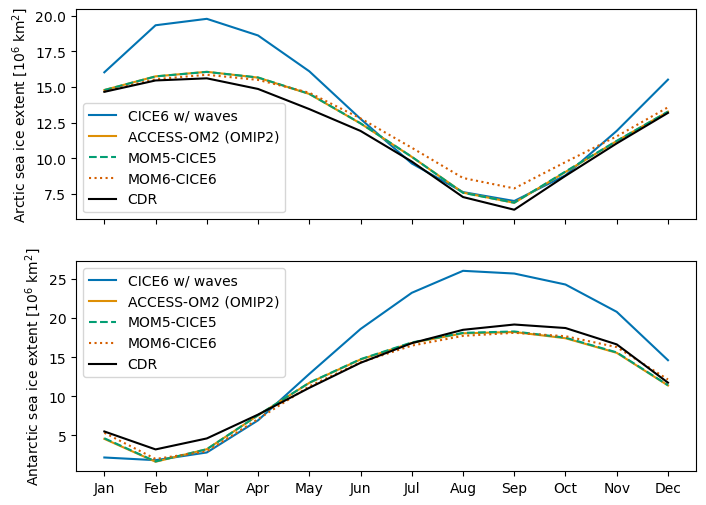

In [131]:
%matplotlib inline
import seaborn as sns
import itertools
import calendar

palette = sns.color_palette("colorblind", n_colors=10)
color_cycle = itertools.cycle(palette)
linewidth = 0.5
linestyles = ['-', '--']
style_cycle = itertools.cycle([(c, ls) for c in palette for ls in linestyles])

fig, axes = plt.subplots(nrows=2, figsize=(8, 6), sharex=True)

# Arctic
for iGroup in model_seasonal_ave_extent_nh_dt.groups[2:]:
    ds = model_seasonal_ave_extent_nh_dt[iGroup].ds
    color = next(color_cycle)
    if iGroup == "/ACCESS-OM2-10 IAF [dev]":
        ls = '--'
        iGroup = "/MOM5-CICE5"
    elif iGroup == "/ACCESS-OM2-10 IAF OMIP2":
        iGroup = "/ACCESS-OM2 (OMIP2)"
    elif iGroup == "/ACCESS-OM3-10 IAF [dev]":
        ls = ":"
        iGroup = "/MOM6-CICE6"
    else:
        ls = '-'

    (ds["climatology"] * 1e-6).plot(ax=axes[0], label=iGroup[1:], linestyle=ls, color=color)

(obs_extent_dt["cdr_nh"].ds.cdr_area.groupby("time.month").mean() * 1e-6).plot(ax=axes[0], label="CDR", color='k')

# Antarctic
# for iGroup in model_seasonal_ave_extent_sh_dt.groups[1:]:
#     ds = model_seasonal_ave_extent_sh_dt[iGroup].ds
#     (ds["FY"] * 1e-6).plot(ax=axes[1], label=iGroup[1:], linestyle='--')

color_cycle = itertools.cycle(palette)
for iGroup in model_seasonal_ave_extent_sh_dt.groups[2:]:
    ds = model_seasonal_ave_extent_sh_dt[iGroup].ds
    color = next(color_cycle)
    if iGroup == "/ACCESS-OM2-10 IAF [dev]":
        ls = '--'
        iGroup = "/MOM5-CICE5"
    elif iGroup == "/ACCESS-OM2-10 IAF OMIP2":
        iGroup = "/ACCESS-OM2 (OMIP2)"
    elif iGroup == "/ACCESS-OM3-10 IAF [dev]":
        ls = ":"
        iGroup = "/MOM6-CICE6"
    else:
        ls = '-'
    (ds["climatology"] * 1e-6).plot(ax=axes[1], label=iGroup[1:], linestyle=ls, color=color)

(obs_extent_dt["cdr_sh"].ds.cdr_area.groupby("time.month").mean() * 1e-6).plot(ax=axes[1], label="CDR", color='k')

# Labels
axes[0].set_ylabel("Arctic sea ice extent [10$^6$ km$^2$]")
axes[1].set_ylabel("Antarctic sea ice extent [10$^6$ km$^2$]")

axes[0].legend()
axes[1].legend()

for ax in axes:
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels([calendar.month_abbr[m] for m in range(1, 13)])
    ax.set_xlabel('')

plt.savefig(f"/home/566/nd0349/access-om3-analysis/figures/SIE_cosima_poster.png", dpi=600, bbox_inches="tight") 
plt.show()

In [160]:
sns.color_palette("Set2", n_colors=10)

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254),
 (0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961)]

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
/jobfs/149026561.gadi-pbs/ipykernel_3613765/4019864372.py:112: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().remove()


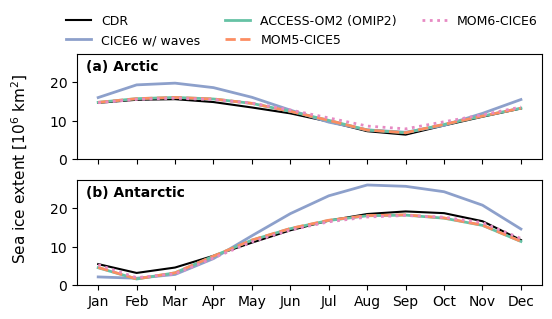

In [164]:
%matplotlib inline
import seaborn as sns
import itertools
import calendar
import matplotlib.pyplot as plt
plt.rcdefaults()

palette = sns.color_palette("Set2", n_colors=10)
palette_custom = [palette[2], palette[0], palette[1], palette[3], palette[4], palette[5], palette[6], palette[7], palette[8], palette[9]]
color_cycle = itertools.cycle(palette_custom)
linewidth = 2

fig, axes = plt.subplots(nrows=2, figsize=(6, 3), sharex=True, sharey=True)

# --- Arctic ---
cdr_series = (obs_extent_dt["cdr_nh"].ds.cdr_area.groupby("time.month").mean() * 1e-6).to_series()
sns.lineplot(
    x=cdr_series.index,
    y=cdr_series.values,
    ax=axes[0],
    label="CDR",
    color='k',
    linewidth=1.5
)

for iGroup in model_seasonal_ave_extent_nh_dt.groups[2:]:
    ds = model_seasonal_ave_extent_nh_dt[iGroup].ds
    series = (ds["climatology"] * 1e-6).to_series()

    color = next(color_cycle)
    if iGroup == "/ACCESS-OM2-10 IAF [dev]":
        ls = '--'
        iGroup = "/MOM5-CICE5"
    elif iGroup == "/ACCESS-OM2-10 IAF OMIP2":
        iGroup = "/ACCESS-OM2 (OMIP2)"
    elif iGroup == "/ACCESS-OM3-10 IAF [dev]":
        ls = ':'
        iGroup = "/MOM6-CICE6"
    else:
        ls = '-'

    sns.lineplot(
        x=series.index,   # already months (1–12)
        y=series.values,
        ax=axes[0],
        label=iGroup[1:],  # strip leading '/'
        color=color,
        linestyle=ls,
        linewidth=linewidth
    )

axes[0].set_ylabel("")
axes[1].set_ylabel("")

# --- Antarctic ---
cdr_series = (obs_extent_dt["cdr_sh"].ds.cdr_area.groupby("time.month").mean() * 1e-6).to_series()
sns.lineplot(
    x=cdr_series.index,
    y=cdr_series.values,
    ax=axes[1],
    label=None,
    color='k',
    linewidth=1.5
)


color_cycle = itertools.cycle(palette_custom)
for iGroup in model_seasonal_ave_extent_sh_dt.groups[2:]:
    ds = model_seasonal_ave_extent_sh_dt[iGroup].ds
    series = (ds["climatology"] * 1e-6).to_series()

    color = next(color_cycle)
    if iGroup == "/ACCESS-OM2-10 IAF [dev]":
        ls = '--'
        iGroup = "/MOM5-CICE5"
    elif iGroup == "/ACCESS-OM2-10 IAF OMIP2":
        iGroup = "/ACCESS-OM2 (OMIP2)"
    elif iGroup == "/ACCESS-OM3-10 IAF [dev]":
        ls = ':'
        iGroup = "/MOM6-CICE6"
    else:
        ls = '-'

    sns.lineplot(
        x=series.index,   # already months (1–12)
        y=series.values,
        ax=axes[1],
        label=None,#iGroup[1:],  # strip leading '/'
        color=color,
        linestyle=ls,
        linewidth=linewidth
    )


fig.text(
    0.03, 0.5,                 # x, y in figure coordinates
    "Sea ice extent [10$^6$ km$^2$]",
    va='center', ha='center',
    rotation='vertical',
    fontsize=11
)

# --- Shared formatting ---
for ax in axes:
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels([calendar.month_abbr[m] for m in range(1, 13)])
    ax.set_xlabel('')
    ax.set_ylim(bottom=0)

# Remove per-axis legends
for ax in axes:
    ax.legend().remove()

# Put one combined legend above axes[0]
fig.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.05),   # move legend above the top subplot
    ncol=3,                       # number of columns (adjust to fit)
    frameon=False,
    fontsize=9
)
axes[0].text(
    0.02, 0.95, "(a) Arctic", transform=axes[0].transAxes,
    fontsize=10, fontweight='bold', va='top', ha='left'
)
axes[1].text(
    0.02, 0.95, "(b) Antarctic", transform=axes[1].transAxes,
    fontsize=10, fontweight='bold', va='top', ha='left'
)

# plt.tight_layout()
plt.savefig("/home/566/nd0349/access-om3-analysis/figures/SIE_cosima_poster.png",
            dpi=600, bbox_inches="tight")
plt.show()

# Sea Ice Area Trends

We are going to compare the trends in the minima and maxima over time, and the monthly climatology

In [76]:
@map_over_subtree
def min_and_max(ds, hemisphere="south"):
    def min_and_max_year(da):
        result = xr.Dataset()
        result["min"] = da.min()
        result["max"] = da.max()
        return result
    if hemisphere == "south":
        annual_min_max_ds = ds.si_area_south.groupby("time.year").apply(min_and_max_year)
    else:
        annual_min_max_ds = ds.si_area_north.groupby("time.year").apply(min_and_max_year)
    return annual_min_max_ds

model_min_max_sh_dt = min_and_max(model_area_sh_dt)
model_min_max_extent_sh_dt = min_and_max(model_extent_sh_dt)

model_min_max_nh_dt = min_and_max(model_area_nh_dt, hemisphere="north")
model_min_max_extent_nh_dt = min_and_max(model_extent_nh_dt, hemisphere="north")

In [77]:
model_extent_sh_dt

DataTree('None', parent=None)
├── DataTree('ACCESS-OM2-10 JRA55-do IAF OMIP2')
│       Dimensions:        (time: 732)
│       Coordinates:
│         * time           (time) datetime64[ns] 6kB 1958-01-31T23:59:00 ... 2018-12-...
│       Data variables:
│           si_area_south  (time) float32 3kB 2.754e+06 2.341e+06 ... 1.235e+07
├── DataTree('ACCESS-OM2-10 JRA55-do IAF [dev]')
│       Dimensions:        (time: 780)
│       Coordinates:
│         * time           (time) datetime64[ns] 6kB 1958-01-31T23:59:00 ... 2022-12-...
│       Data variables:
│           si_area_south  (time) float64 6kB 2.754e+06 2.341e+06 ... 1.173e+07
└── DataTree('ACCESS-OM3-10 JRA55-do IAF [dev]')
        Dimensions:        (time: 228)
        Coordinates:
          * time           (time) datetime64[ns] 2kB 1958-01-16T12:00:00 ... 1976-12-...
        Data variables:
            si_area_south  (time) float64 2kB 2.684e+06 2.4e+06 ... 1.64e+07 1.194e+07

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'


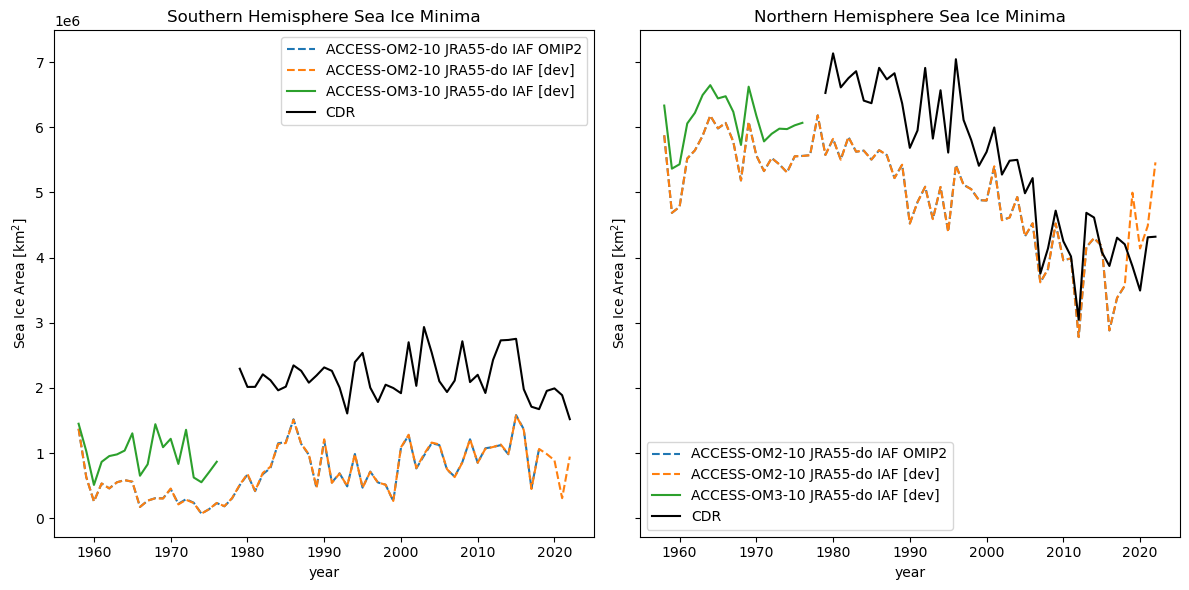

In [78]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Southern Hemisphere subplot
ax = axes[0]
for iGroup in model_min_max_sh_dt.groups[1:]:
    ds = model_min_max_sh_dt[iGroup].ds
    if iGroup[1:11] == 'ACCESS-OM2':
        linestyle = '--'
    else:
        linestyle = '-'
    
    if len(ds["min"]) == 1:
        ax.scatter(ds["min"].coords["year"], ds["min"].values, label=iGroup[1:])
    else:
        ds["min"].plot(ax=ax, label=iGroup[1:], linestyle=linestyle)

obs_area_dt["cdr_sh"].ds.cdr_area.groupby("time.year").min().plot(ax=ax, label="CDR", color='k')

ax.set_title("Southern Hemisphere Sea Ice Minima")
ax.set_ylabel("Sea Ice Area [km$^2$]")
ax.legend()

# Northern Hemisphere subplot
ax = axes[1]
for iGroup in model_min_max_nh_dt.groups[1:]:
    ds = model_min_max_nh_dt[iGroup].ds
    if iGroup[1:11] == 'ACCESS-OM2':
        linestyle = '--'
    else:
        linestyle = '-'
    if len(ds["min"]) == 1:
        ax.scatter(ds["min"].coords["year"], ds["min"].values, label=iGroup[1:])
    else:
        ds["min"].plot(ax=ax, label=iGroup[1:], linestyle=linestyle)

obs_area_dt["cdr_nh"].ds.cdr_area.groupby("time.year").min().plot(ax=ax, label="CDR", color='k')

ax.set_ylabel("Sea Ice Area [km$^2$]")
ax.set_title("Northern Hemisphere Sea Ice Minima")
ax.legend()

plt.tight_layout()
plt.savefig("/home/566/nd0349/access-om3-analysis/figures/climatology_sea_ice_area_min_subplot.png", dpi=300, bbox_inches="tight")
plt.show()

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'


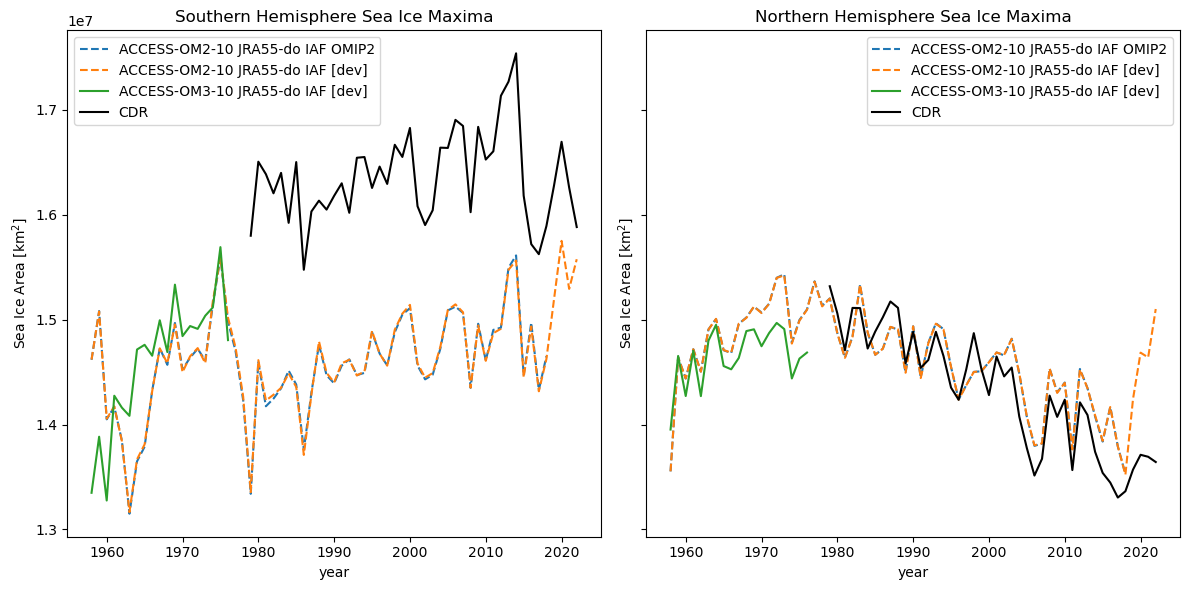

In [79]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Southern Hemisphere subplot
ax = axes[0]
for iGroup in model_min_max_sh_dt.groups[1:]:
    ds = model_min_max_sh_dt[iGroup].ds
    if iGroup[1:11] == 'ACCESS-OM2':
        linestyle = '--'
    else:
        linestyle = '-'
    
    if len(ds["min"]) == 1:
        ax.scatter(ds["max"].coords["year"], ds["max"].values, label=iGroup[1:])
    else:
        ds["max"].plot(ax=ax, label=iGroup[1:], linestyle=linestyle)

obs_area_dt["cdr_sh"].ds.cdr_area.groupby("time.year").max().plot(ax=ax, label="CDR", color='k')

ax.set_title("Southern Hemisphere Sea Ice Maxima")
ax.set_ylabel("Sea Ice Area [km$^2$]")
ax.legend()

# Northern Hemisphere subplot
ax = axes[1]
for iGroup in model_min_max_nh_dt.groups[1:]:
    ds = model_min_max_nh_dt[iGroup].ds
    if iGroup[1:11] == 'ACCESS-OM2':
        linestyle = '--'
    else:
        linestyle = '-'
        
    if len(ds["max"]) == 1:
        ax.scatter(ds["max"].coords["year"], ds["max"].values, label=iGroup[1:])
    else:
        ds["max"].plot(ax=ax, label=iGroup[1:], linestyle=linestyle)

obs_area_dt["cdr_nh"].ds.cdr_area.groupby("time.year").max().plot(ax=ax, label="CDR", color='k')

ax.set_ylabel("Sea Ice Area [km$^2$]")
ax.set_title("Northern Hemisphere Sea Ice Maxima")
ax.legend()

plt.tight_layout()
plt.savefig("/home/566/nd0349/access-om3-analysis/figures/climatology_sea_ice_area_max_subplot.png", dpi=300, bbox_inches="tight")
plt.show()

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'


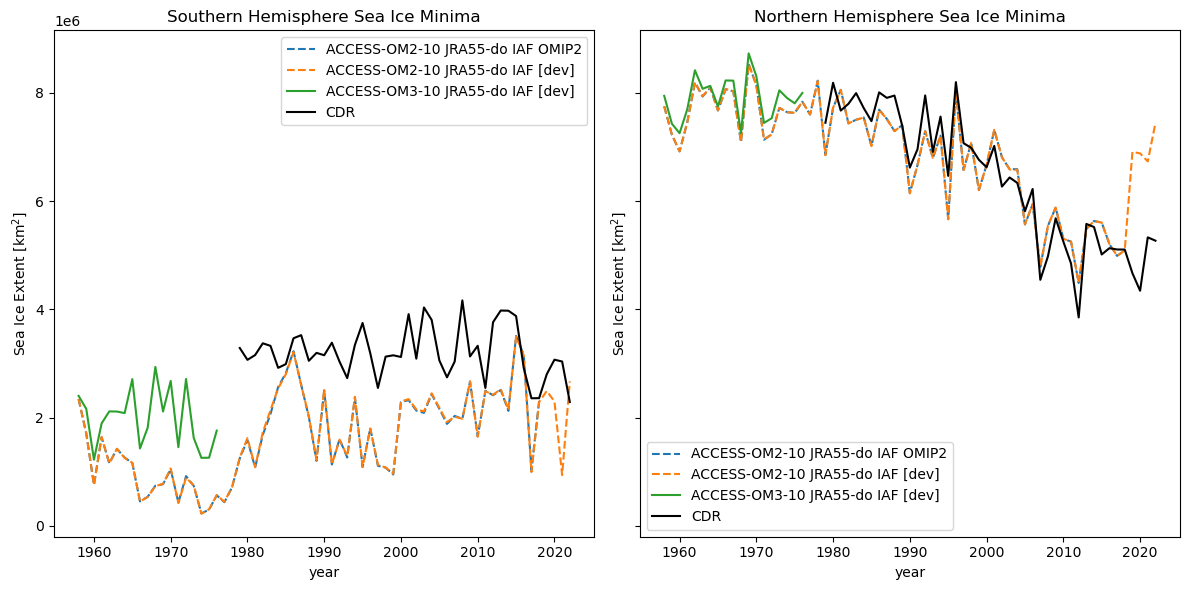

In [80]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Southern Hemisphere subplot
ax = axes[0]
for iGroup in model_min_max_extent_sh_dt.groups[1:]:
    ds = model_min_max_extent_sh_dt[iGroup].ds
    if iGroup[1:11] == 'ACCESS-OM2':
        linestyle = '--'
    else:
        linestyle = '-'
    
    if len(ds["min"]) == 1:
        ax.scatter(ds["min"].coords["year"], ds["min"].values, label=iGroup[1:])
    else:
        ds["min"].plot(ax=ax, label=iGroup[1:], linestyle=linestyle)

obs_extent_dt["cdr_sh"].ds.cdr_area.groupby("time.year").min().plot(ax=ax, label="CDR", color='k')

ax.set_title("Southern Hemisphere Sea Ice Minima")
ax.set_ylabel("Sea Ice Extent [km$^2$]")
ax.legend()

# Northern Hemisphere subplot
ax = axes[1]
for iGroup in model_min_max_extent_nh_dt.groups[1:]:
    ds = model_min_max_extent_nh_dt[iGroup].ds
    if iGroup[1:11] == 'ACCESS-OM2':
        linestyle = '--'
    else:
        linestyle = '-'
    if len(ds["min"]) == 1:
        ax.scatter(ds["min"].coords["year"], ds["min"].values, label=iGroup[1:])
    else:
        ds["min"].plot(ax=ax, label=iGroup[1:], linestyle=linestyle)

obs_extent_dt["cdr_nh"].ds.cdr_area.groupby("time.year").min().plot(ax=ax, label="CDR", color='k')

ax.set_ylabel("Sea Ice Extent [km$^2$]")
ax.set_title("Northern Hemisphere Sea Ice Minima")
ax.legend()

plt.tight_layout()
plt.savefig("/home/566/nd0349/access-om3-analysis/figures/climatology_sea_ice_extent_min_subplot.png", dpi=300, bbox_inches="tight")
plt.show()

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'


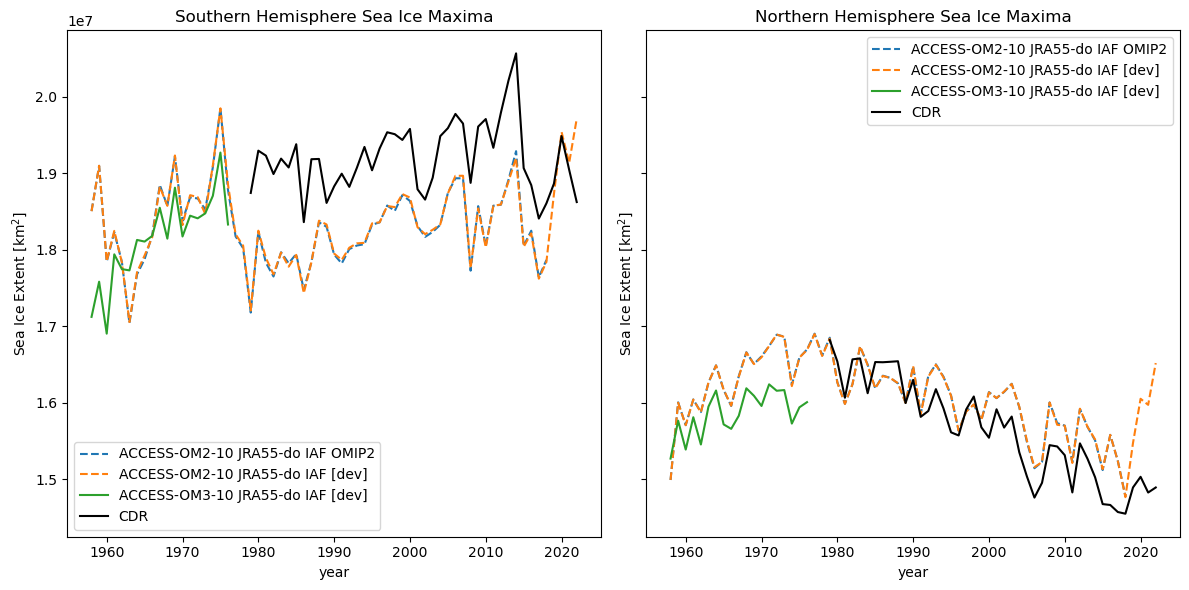

In [81]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Southern Hemisphere subplot
ax = axes[0]
for iGroup in model_min_max_extent_sh_dt.groups[1:]:
    ds = model_min_max_extent_sh_dt[iGroup].ds
    if iGroup[1:11] == 'ACCESS-OM2':
        linestyle = '--'
    else:
        linestyle = '-'
    
    if len(ds["min"]) == 1:
        ax.scatter(ds["max"].coords["year"], ds["max"].values, label=iGroup[1:])
    else:
        ds["max"].plot(ax=ax, label=iGroup[1:], linestyle=linestyle)

obs_extent_dt["cdr_sh"].ds.cdr_area.groupby("time.year").max().plot(ax=ax, label="CDR", color='k')

ax.set_title("Southern Hemisphere Sea Ice Maxima")
ax.set_ylabel("Sea Ice Extent [km$^2$]")
ax.legend()

# Northern Hemisphere subplot
ax = axes[1]
for iGroup in model_min_max_extent_nh_dt.groups[1:]:
    ds = model_min_max_extent_nh_dt[iGroup].ds
    if iGroup[1:11] == 'ACCESS-OM2':
        linestyle = '--'
    else:
        linestyle = '-'
        
    if len(ds["max"]) == 1:
        ax.scatter(ds["max"].coords["year"], ds["max"].values, label=iGroup[1:])
    else:
        ds["max"].plot(ax=ax, label=iGroup[1:], linestyle=linestyle)

obs_extent_dt["cdr_nh"].ds.cdr_area.groupby("time.year").max().plot(ax=ax, label="CDR", color='k')

ax.set_ylabel("Sea Ice Extent [km$^2$]")
ax.set_title("Northern Hemisphere Sea Ice Maxima")
ax.legend()

plt.tight_layout()
plt.savefig("/home/566/nd0349/access-om3-analysis/figures/climatology_sea_ice_extent_max_subplot.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# # Southern Hemisphere subplot
# ax = axes[0]
# for iGroup in model_min_max_extent_sh_dt.groups[1:]:
#     ds = model_min_max_extent_sh_dt[iGroup].ds
#     if iGroup[1:11] == 'ACCESS-OM2':
#         linestyle = '--'
#     else:
#         linestyle = '-'
#     if len(ds["min"]) == 1:
#         ax.scatter(ds["min"].coords["year"], ds["min"].values, label=iGroup[1:])
#     else:
#         ds["min"].plot(ax=ax, label=iGroup[1:], linestyle=linestyle)

# obs_area_dt["cdr_sh"].ds.cdr_area.groupby("time.year").min().plot(ax=ax, label="CDR", color='k')

# ax.set_title("Southern Hemisphere Sea Ice Minima")
# ax.set_ylabel("Sea Ice Extent [km$^2$]")
# ax.legend()

# # Northern Hemisphere subplot
# ax = axes[1]
# for iGroup in model_min_max_extent_nh_dt.groups[1:]:
#     ds = model_min_max_extent_nh_dt[iGroup].ds
#     if iGroup[1:11] == 'ACCESS-OM2':
#         linestyle = '--'
#     else:
#         linestyle = '-'
#     if len(ds["min"]) == 1:
#         ax.scatter(ds["min"].coords["year"], ds["min"].values, label=iGroup[1:])
#     else:
#         ds["min"].plot(ax=ax, label=iGroup[1:],linestyle=linestyle)

# obs_area_dt["cdr_nh"].ds.cdr_area.groupby("time.year").min().plot(ax=ax, label="CDR", color='k')

# ax.set_ylabel("Sea Ice Extent [km$^2$]")
# ax.set_title("Northern Hemisphere Sea Ice Minima")
# ax.legend()

# plt.tight_layout()
# plt.savefig("/home/566/nd0349/access-om3-analysis/figures/climatology_sea_ice_area_min_subplot.png", dpi=300, bbox_inches="tight")
# plt.show()

In [ ]:
obs_extent_dt["cdr_sh"]

In [82]:
plt.close()

for iGroup in model_min_max_dt.groups[1:]:
    ds = model_min_max_dt[iGroup].ds.sel(
        year=slice(1900, 2022)
    )  # drop 2023 because its incomplete
    # ds["max"].plot(label=iGroup[1:])
    # ds = model_min_max_dt[iGroup]
    if len(ds["max"]) == 1:
        plt.scatter(ds["max"].coords["year"], ds["max"].values, label=iGroup[1:])
    else:
        ds["max"].plot(label=iGroup[1:])

obs_area_dt["cdr_sh"].ds.cdr_area.groupby("time.year").max().plot(label="CDR", color='k')

plt.title("Trends in Sea Ice Maxima")
plt.ylabel("Sea Ice Area [km$^2$]")

_ = plt.legend()
plt.savefig("/home/566/nd0349/access-om3-analysis/figures/climatology_sea_ice_area_max.png", dpi=300, bbox_inches="tight")

NameError: name 'model_min_max_dt' is not defined

In [ ]:
plt.close()

for iGroup in model_min_max_extent_dt.groups[1:]:
    ds = model_min_max_extent_dt[iGroup].ds.sel(
        year=slice(1900, 2022)
    )  # drop 2023 because its incomplete
    # ds["max"].plot(label=iGroup[1:])
    # ds = model_min_max_dt[iGroup]
    if len(ds["max"]) == 1:
        plt.scatter(ds["max"].coords["year"], ds["max"].values, label=iGroup[1:])
    else:
        ds["max"].plot(label=iGroup[1:])

obs_extent_dt["cdr_sh"].ds.cdr_area.groupby("time.year").max().plot(label="CDR", color='k')

plt.title("Trends in Sea Ice Maxima")
plt.ylabel("Sea Ice Extent [km$^2$]")

_ = plt.legend(loc='upper left')
plt.savefig("/home/566/nd0349/access-om3-analysis/figures/climatology_sea_ice_extent_max.png", dpi=300, bbox_inches="tight")

In [83]:
for iGroup in model_area_dt.groups[1:]:
    (climatology(model_area_dt[iGroup].ds.si_area)*1e-6).plot(label=iGroup[1:])


(climatology(obs_area_dt["cdr_sh"].ds.cdr_area)*1e-6).plot(label="CDR satellite obs.", color='k')


plt.title("Climatology of Sea Ice Area")
plt.xlabel("Month")
plt.ylabel("Sea ice area [$10^6$ km$^2$]")
plt.ylim([0,20])
plt.legend()
plt.savefig("/home/566/nd0349/access-om3-analysis/figures/climatology_sea_ice_area.png", dpi=300, bbox_inches="tight")

NameError: name 'model_area_dt' is not defined

In [35]:
for iGroup in model_area_dt.groups[1:]:
    (climatology(model_extent_dt[iGroup].ds.si_area)*1e-6).plot(label=iGroup[1:])

(climatology(obs_extent_dt["cdr_sh"].ds.cdr_area)*1e-6).plot(label="CDR satellite obs.", color='k')

plt.title("Climatology of Sea Ice Extent")
plt.xlabel("Month")
plt.ylabel("Sea ice extent [$10^6$ km$^2$]")
plt.ylim([0,20])
plt.legend()
plt.savefig("/home/566/nd0349/access-om3-analysis/figures/climatology_sea_ice_extent.png", dpi=300, bbox_inches="tight")

NameError: name 'model_area_dt' is not defined

We see all model runs have too low sea ice in summer, and grow faster than observations in autumn and earlier that the observed maximum.

# Sea Ice Concentration Anomalies

To examine the differences between the model results and observations, we calculate difference in each grid cell between observations and each experiment

As that data are on different grids, we need to regrid to compare the datasets

Lets simplify a little to only look at 0.25 degree results

In [84]:
groups = ("/ACCESS-OM3-10 JRA55-do IAF [dev]", "/ACCESS-OM3-10 JRA55-do IAF [dev]")

The lat/lon of of each cell in the observational dataset are in a different file:

In [85]:
! wget -nc https://noaadata.apps.nsidc.org/NOAA/G02202_V4/ancillary/G02202-cdr-ancillary-sh.nc

File ‘G02202-cdr-ancillary-sh.nc’ already there; not retrieving.



In [86]:
cdr_sps_ds = xr.open_dataset("G02202-cdr-ancillary-sh.nc")

We can now build the re-gridder. This is described in detail in [DocumentedExamples/Regridding](https://cosima-recipes.readthedocs.io/en/latest/DocumentedExamples/Regridding.html)

In [87]:
si_dt
# 
# aice.sel(month=1).max()
# climatology
# aice_sh_anom_ds[iGroup]
# # iMonth

DataTree('None', parent=None)
├── DataTree('ACCESS-OM2-10 JRA55-do IAF OMIP2')
│       Dimensions:   (time: 732, yt_ocean: 300, xt_ocean: 360)
│       Coordinates:
│         * time      (time) datetime64[ns] 6kB 1958-01-31T23:59:00 ... 2018-12-31T23...
│         * xt_ocean  (xt_ocean) float64 3kB -279.5 -278.5 -277.5 ... 77.5 78.5 79.5
│         * yt_ocean  (yt_ocean) float64 2kB -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
│           geolat_t  (yt_ocean, xt_ocean) float32 432kB nan nan nan ... 65.63 65.21
│           geolon_t  (yt_ocean, xt_ocean) float32 432kB nan nan nan ... 79.97 79.99
│           area_t    (yt_ocean, xt_ocean) float32 432kB nan nan ... 1.121e+08 3.857e+07
│       Data variables:
│           aice_m    (time, yt_ocean, xt_ocean) float32 316MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
│           hi_m      (time, yt_ocean, xt_ocean) float32 316MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
│       Attributes: (12/18)
│           title:                                    sea ice model output for CICE
│           contents:                                 Diagnostic and Prognostic Varia...
│           source:                                   Los Alamos Sea Ice Model (CICE)...
│           time_period_freq:                         month_1
│           comment3:                                 seconds elapsed into model date...
│           conventions:                              CF-1.0
│           ...                                       ...
│           intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...
│           intake_esm_attrs:variable_cell_methods:   ,,,,,,,,,,,,,,,,,,time: mean,ti...
│           intake_esm_attrs:variable_units:          days since 1958-01-01 00:00:00,...
│           intake_esm_attrs:file_id:                 iceh_XXXX_XX
│           intake_esm_attrs:_data_format_:           netcdf
│           intake_esm_dataset_key:                   iceh_XXXX_XX.1mon
├── DataTree('ACCESS-OM2-10 JRA55-do IAF [dev]')
│       Dimensions:   (time: 780, yt_ocean: 300, xt_ocean: 360)
│       Coordinates:
│         * time      (time) datetime64[ns] 6kB 1958-01-31T23:59:00 ... 2022-12-31T23...
│           TLON      (yt_ocean, xt_ocean) float32 432kB dask.array<chunksize=(150, 180), meta=np.ndarray>
│           TLAT      (yt_ocean, xt_ocean) float32 432kB dask.array<chunksize=(150, 180), meta=np.ndarray>
│         * xt_ocean  (xt_ocean) int64 3kB 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
│         * yt_ocean  (yt_ocean) int64 2kB 0 1 2 3 4 5 6 ... 293 294 295 296 297 298 299
│           ulat      (yt_ocean, xt_ocean) float64 864kB dask.array<chunksize=(300, 360), meta=np.ndarray>
│           ulon      (yt_ocean, xt_ocean) float64 864kB dask.array<chunksize=(300, 360), meta=np.ndarray>
│           geolat_t  (yt_ocean, xt_ocean) float64 864kB dask.array<chunksize=(300, 360), meta=np.ndarray>
│           geolon_t  (yt_ocean, xt_ocean) float64 864kB dask.array<chunksize=(300, 360), meta=np.ndarray>
│           area_t    (yt_ocean, xt_ocean) float64 864kB dask.array<chunksize=(300, 360), meta=np.ndarray>
│       Data variables:
│           hi_m      (time, yt_ocean, xt_ocean) float32 337MB dask.array<chunksize=(1, 150, 180), meta=np.ndarray>
│           aice_m    (time, yt_ocean, xt_ocean) float32 337MB dask.array<chunksize=(1, 150, 180), meta=np.ndarray>
│       Attributes:
│           title:             sea ice model output for CICE
│           contents:          Diagnostic and Prognostic Variables
│           source:            Los Alamos Sea Ice Model (CICE) Version 5
│           time_period_freq:  month_1
│           comment:           This year has 365 days
│           comment2:          File written on model date 19580201
│           comment3:          seconds elapsed into model date:      0
│           conventions:       CF-1.0
│           history:           This dataset was created on 2025-03-17 at 10:24
│           io_flavor:         io_pio
└── DataTree('ACCES

In [88]:
regridder_ACCESSOM2_025deg_sh = xesmf.Regridder(
    si_dt["ACCESS-OM2-10 JRA55-do IAF OMIP2"].ds.isel(time=0).drop_vars(["xt_ocean", "yt_ocean"]),
    cdr_sps_ds,
    "bilinear",
    periodic=True,
    unmapped_to_nan=True,
)

--------------------------------------------------------------------------
but there are no active ports detected (or Open MPI was unable to use
them).  This is most certainly not what you wanted.  Check your
cables, subnet manager configuration, etc.  The openib BTL will be
ignored for this job.

  Local host: gadi-cpu-bdw-0032
--------------------------------------------------------------------------


In [89]:
aice_sh_3976_ds = xr.Dataset()
aice_sh_anom_ds = xr.Dataset()

groups = si_dt.groups

for iG in groups:
    aice_sh_3976_ds[iG] = regridder_ACCESSOM2_025deg_sh(
        si_dt[iG].ds.aice_m.copy()
    )
    aice_sh_anom_ds[iG] = aice_sh_3976_ds[iG] - cdr_dt["cdr_sh"].ds.cdr_conc

AttributeError: 'DatasetView' object has no attribute 'aice_m'

We can now plot the difference between modelled and observed sea ice concentration

In [ ]:
months = [2, 9]  # february, september
month_names = ["Feb", "Sep"]
n_months = len(months)

plt.figure(figsize=(9, n_months * 3))

cdr = climatology(cdr_dt["cdr_sh"].ds.cdr_conc)

for j, iGroup in enumerate(aice_sh_anom_ds.data_vars):
    anoms = climatology(aice_sh_anom_ds[iGroup])
    aice = climatology(aice_sh_3976_ds[iGroup])
    # anoms = aice_sh_anom_ds[iGroup]
    # aice = aice_sh_3976_ds[iGroup]

    for i, iMonth in enumerate(months):
        plt.subplot(
            n_months,
            3,
            j + 1 + i * 3,
            projection=ccrs.SouthPolarStereo(true_scale_latitude=-70),
        )

        # Filled contours with concentration anomalies in this month
        ds = anoms.sel(month=iMonth).compute()
        plt.contourf(
            ds.x, ds.y, ds, levels=np.arange(-0.85, 0.86, 0.1), cmap=cmo.balance_r
        )

        # Lines at 15% concentration (approx ice edge)
        cs_cdr = cdr.sel(month=iMonth).plot.contour(levels=[0.15])
        cs_mod = aice.sel(month=iMonth).plot.contour(levels=[0.15], colors=["black"])

        plt.title(month_names[i] + "_" + iGroup[1:])

# Messy legend creation
color_cdr = cs_cdr.collections[0].get_edgecolor()
line_cdr = mlines.Line2D([], [], color=color_cdr, label="Observed Extent")

color_mod = cs_mod.collections[0].get_edgecolor()
line_mod = mlines.Line2D([], [], color=color_mod, label="Modelled Extent")

plt.legend(handles=[line_cdr, line_mod], loc="center left", bbox_to_anchor=(1.2, 0.5))

# And colorbar
cax = plt.axes([0.7, 0.6, 0.05, 0.2])
_ = plt.colorbar(cax=cax, label="Difference in \nSea Ice Concentration")

We see that OM2 under-represents sea ice in Summer, particularly in the Weddell Sea. In Winter, trends are less clear, although ERA5 forced sea ice concentration is too high at the northern boundary.

In [ ]:
aice_sh_anom_ds.data_vars
aice_sh_anom_ds
# aice_sh_3976_ds["/ACCESS-OM3-10 JRA55-do RYF [dev]"].isel(time=-100).plot()

# si_dt["ACCESS-OM3-10 JRA55-do RYF [dev]"].ds.isel(time=0)["aice_m"].plot()

# si_dt[iGroup].ds.isel(time=0)["aice_m"]
# ds
# axes
si_dt.groups[1:]
len(si_dt.groups[1:])

si_dt.groups[1:]

# ds.plot()
# si_dt.groups[1:]
si_dt['/ACCESS-OM2-10 JRA55-do IAF OMIP2'].ds.isel(time=9)["aice_m"].plot(cmap=cmo.ice)

### Map of sea ice concentration

Data formatted


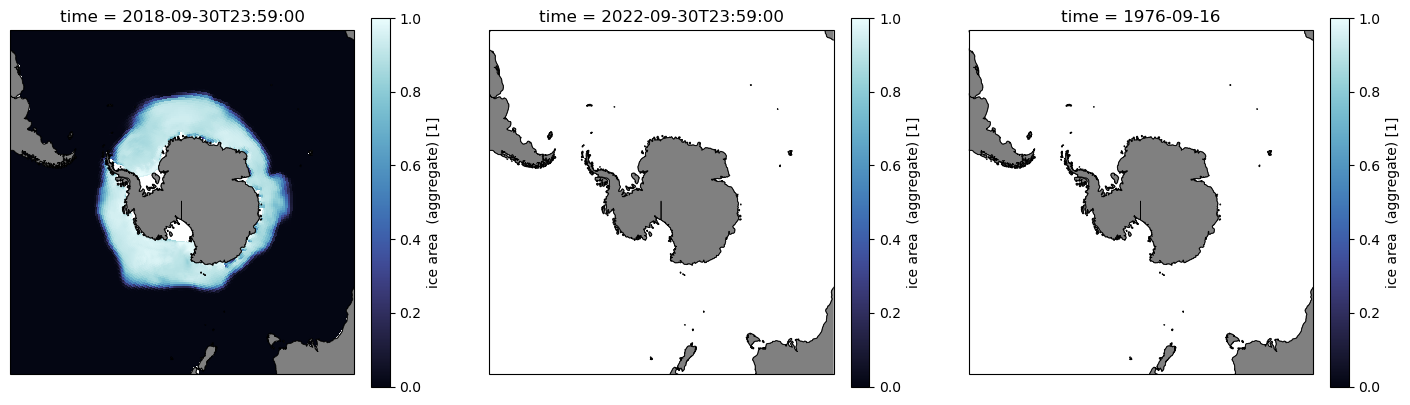

In [90]:

# Create subplots with proper projection and improved spacing
nrows, ncols = 1,len(si_dt.groups[1:])
fig, axes = plt.subplots(nrows=nrows, 
                         ncols=ncols,  
                         figsize=(14, 4 * nrows),  # Adjust height dynamically
                         constrained_layout=True,
                         subplot_kw={'projection': ccrs.SouthPolarStereo(true_scale_latitude=-70)},
                         # projection=ccrs.SouthPolarStereo(true_scale_latitude=-70)
                         gridspec_kw={'wspace': 0.1, 'hspace': 0.15})  # Adjust spacing

# Flatten axes for iteration safety
if nrows > 1:
    axes = axes.flatten()
else:
    axes = np.array([axes]).flatten()  # Ensure a consistent structure if `nrows == 1`

# Add coastlines and land features
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                   edgecolor='black',
                                   facecolor='gray', linewidth=0.5)

for ax in axes:
    ax.set_global()
    ax.coastlines(resolution='50m')
    ax.add_feature(land_50m)
    ax.set_extent([-180, 180, -90, -40], crs=ccrs.PlateCarree())



# Find global min and max for consistent color scale
# all_data = []
all_data = []
all_data = [
    ds1.sel(time=ds1.time.where(ds1.time.dt.month == 9, drop=True).isel(time=-1))["aice_m"]
    .squeeze()
    .where(ds1["geolat_t"] < 0)  # Keep only Southern Hemisphere data
    .compute()  # Convert from Dask to NumPy
    .chunk()  # Ensure it's a single chunk
    for iGroup in si_dt.groups[1:4]
    if (ds1 := si_dt[iGroup].ds) is not None  # Ensure ds1 is valid
]
print("Data formatted")

for i, iGroup in enumerate(si_dt.groups[1:4]):
    im = all_data[i].plot.pcolormesh(cmap=cmo.ice, transform=ccrs.PlateCarree(),
                                 vmin=0, vmax=1, add_colorbar=True, ax=axes[i])

#     # closest_september_time1 = ds1.time.where(ds1.time.dt.month == 9, drop=True).isel(time=-1)
#     # data1 = ds1.sel(time=closest_september_time1)["tos"].squeeze()
#     # all_data.append(data1.values)
# ds1
# # vmin = np.nanmin(all_data)
# # vmax = np.nanmax(all_data)

# # Plot data with consistent color scale and add subplot labels
# for i, iGroup in enumerate(si_dt.groups[1:]):
#     if i >= len(axes):  # Safety check
#         break

    # ds1 = si_dt[iGroup].ds
    # closest_september_time1 = ds1.time.where(ds1.time.dt.month == 9, drop=True).isel(time=-1)
    # data1 = ds1.sel(time=closest_september_time1)["tos"].squeeze()

    # # Plot with consistent vmin/vmax
    # im = data1.plot.pcolormesh(ax=axes[i], cmap=cmo.thermal, transform=ccrs.PlateCarree(),
    #                            vmin=vmin, vmax=vmax, add_colorbar=True)
    # axes[i].set_title(f"{iGroup[1:]}: {closest_september_time1.dt.strftime('%Y-%m-%d').values}")
# plt.savefig("/home/566/nd0349/access-om3-analysis/figures/sst_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

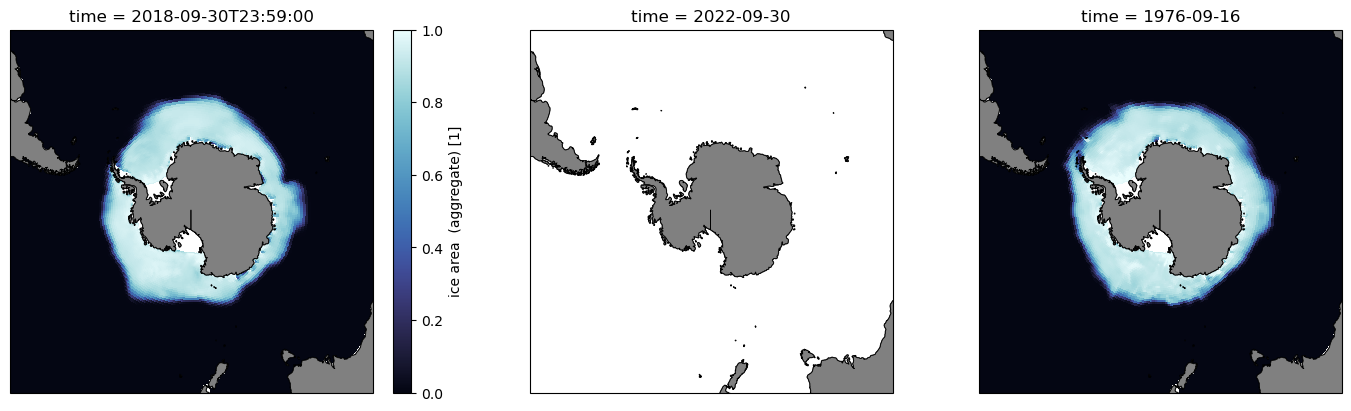

In [91]:
fig, axes = plt.subplots(nrows=1, 
                         ncols=3,  
                         figsize=(14, 4 * 1),  # Adjust height dynamically
                         constrained_layout=True,
                         subplot_kw={'projection': ccrs.SouthPolarStereo(true_scale_latitude=-70)},
                         # projection=ccrs.SouthPolarStereo(true_scale_latitude=-70)
                         gridspec_kw={'wspace': 0.1, 'hspace': 0.15})  # Adjust spacing

# Flatten axes for iteration safety

# Add coastlines and land features
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                   edgecolor='black',
                                   facecolor='gray', linewidth=0.5)

for ax in axes:
    ax.set_global()
    ax.coastlines(resolution='50m')
    ax.add_feature(land_50m)
    ax.set_extent([-180, 180, -90, -40], crs=ccrs.PlateCarree())

all_data = []
all_data = [
    ds1.sel(time=ds1.time.where(ds1.time.dt.month == 9, drop=True).isel(time=-1))["aice_m"]
    .squeeze()
    .where(ds1["geolat_t"] < 0)  # Keep only Southern Hemisphere data
    .compute()  # Convert from Dask to NumPy
    .chunk()  # Ensure it's a single chunk
    for iGroup in si_dt.groups[1:4]
    if (ds1 := si_dt[iGroup].ds) is not None  # Ensure ds1 is valid
]
# Plot
# im = all_data[2].plot.pcolormesh(cmap=cmo.ice, ax=axes, transform=ccrs.PlateCarree(),
                                 # vmin=0, vmax=1, add_colorbar=True)


# all_data[1].plot(ax=axes[0], transform=ccrs.PlateCarree(),)
for i in range(3):
    if RUN_DICT[list(RUN_DICT.keys())[i]]['model'] == "access-om2":
        all_data[i].plot(ax=axes[i], shading='auto', cmap=cmo.ice, transform=ccrs.PlateCarree(), vmin=0, vmax=1)
    else:
        axes[i].pcolormesh(all_data[i]['geolon_t'], all_data[i]['geolat_t'], all_data[i], 
                           shading='auto', cmap=cmo.ice, transform=ccrs.PlateCarree(), vmin=0, vmax=1)
        axes[i].set_title(f"time = {all_data[i].time.dt.strftime('%Y-%m-%d').values}")


In [ ]:
%matplotlib inline
# ds1["aice_m"].isel(time=0).plot(x="geolon_t", y="geolat_t")
# ds1["aice_m"].isel(time=0)
print(ds1["geolon_t"].isnull().sum().compute().item(), ds1["geolat_t"].isnull().sum().compute().item())

In [ ]:
months = [1, 9]  # february, september
month_names = ["Feb", "Sep"]
n_months = len(months)
plt.close()


fig, axes = plt.subplots(
    n_months, 3, 
    figsize=(9, n_months * 3), 
    subplot_kw={'projection': ccrs.SouthPolarStereo(true_scale_latitude=-70)}
)

# Set extent to only show the Southern Hemisphere
for ax in axes.flat:
    ax.set_extent([-180, 180, -90, -50], crs=ccrs.PlateCarree())


# for j, iGroup in enumerate(si_dt.groups[1:]):
    # print(iGroup)
    # print(j)
    # Filled contours with concentration anomalies in this month
ds = si_dt['/ACCESS-OM2-10 JRA55-do IAF OMIP2'].ds.isel(time=months[1])["aice_m"]
axes[0,0].contourf(
    ds.geolon_t, ds.geolat_t, ds, levels=np.arange(0, 1, 0.1), cmap=cmo.ice, transform=ccrs.PlateCarree()
)
    
    
ds = si_dt['/ACCESS-OM3-10 JRA55-do RYF [dev]'].ds.isel(time=6)["aice_m"]
axes[0,1].contourf(
    ds.geolon_t, ds.geolat_t, ds, levels=np.arange(0, 1, 0.1), cmap=cmo.ice, transform=ccrs.PlateCarree()
)

ds = si_dt['/ACCESS-OM3-10 JRA55-do RYF [dev]'].ds.isel(time=months[0])["aice_m"]
axes[0,2].contourf(
    ds.geolon_t, ds.geolat_t, ds, levels=np.arange(0, 1, 0.1), cmap=cmo.ice, transform=ccrs.PlateCarree()
)
    
    
ds = si_dt['/ACCESS-OM3-10 JRA55-do RYF [dev]'].ds.isel(time=9)["aice_m"]
axes[1,1].contourf(
    ds.geolon_t, ds.geolat_t, ds, levels=np.arange(0, 1, 0.1), cmap=cmo.ice, transform=ccrs.PlateCarree()
)

for ax in axes.flat:
    ax.coastlines()




# for j, iGroup in enumerate(si_dt.groups[1:]):
#     # anoms = climatology(aice_sh_anom_ds[iGroup])
#     # aice = climatology(aice_sh_3976_ds[iGroup])
#     # anoms = aice_sh_anom_ds[iGroup]
#     # aice = aice_sh_3976_ds[iGroup]
#     aice = si_dt[iGroup].ds["aice_m"]

#     for i, iMonth in enumerate(months):
#         plt.subplot(
#             n_months,
#             3,
#             j + 1 + i * 3,
#             projection=ccrs.SouthPolarStereo(true_scale_latitude=-70),
#         )

#         # Filled contours with concentration anomalies in this month
#         ds = aice.sel(month=iMonth).compute()
#         plt.contourf(
#             ds.x, ds.y, ds, levels=np.arange(-0.85, 0.86, 0.1), cmap=cmo.balance_r
#         )

    #     # Lines at 15% concentration (approx ice edge)
    #     cs_cdr = cdr.sel(month=iMonth).plot.contour(levels=[0.15])
    #     cs_mod = aice.sel(month=iMonth).plot.contour(levels=[0.15], colors=["black"])

    #     plt.title(month_names[i] + "_" + iGroup[1:])

# # Messy legend creation
# color_cdr = cs_cdr.collections[0].get_edgecolor()
# line_cdr = mlines.Line2D([], [], color=color_cdr, label="Observed Extent")

# color_mod = cs_mod.collections[0].get_edgecolor()
# line_mod = mlines.Line2D([], [], color=color_mod, label="Modelled Extent")

# plt.legend(handles=[line_cdr, line_mod], loc="center left", bbox_to_anchor=(1.2, 0.5))

# # And colorbar
# cax = plt.axes([0.7, 0.6, 0.05, 0.2])
# _ = plt.colorbar(cax=cax, label="Difference in \nSea Ice Concentration")

# Sea Ice Volume

We can calculate volume in much the same way as area, except _vicen_ is volume (per unit area) in each of 5 thickness classes, so we can sum this for the volume irrespective of thickness. 

In [ ]:
# .where(ds.geolat_t<0)

@map_over_subtree
def sea_ice_vol_model_sh(ds):
    # vice_m = ds.hi_m.sel(yt_ocean=slice(-90, 0))
    vice_m = ds.hi_m.where(ds.geolat_t<0)
    siv_total_da = (
        (vice_m * ds.area_t)
        .where(~np.isnan(ds.area_t))
        .cf.sum(["xt_ocean", "yt_ocean"])
    )

    return siv_total_da.to_dataset(name="si_vol").load()

In [ ]:
si_vol_dt = sea_ice_vol_model_sh(si_dt)

In [ ]:
@map_over_subtree
def min_and_max(ds):
    def min_and_max_year(da):
        result = xr.Dataset()
        result["min"] = da.min()
        result["max"] = da.max()
        return result

    annual_min_max_ds = ds.si_vol.groupby("time.year").apply(min_and_max_year)
    return annual_min_max_ds


model_min_max_dt = min_and_max(si_vol_dt)

In [ ]:
for iGroup in model_min_max_dt.groups[1:]:
    ds = model_min_max_dt[iGroup].ds
    ds["min"].plot(label=iGroup[1:])

plt.title("Trends in Sea-Ice Minimum Volume")
plt.ylabel("Sea-Ice Volume (m$^3$)")

_ = plt.legend()

In [ ]:
for iGroup in model_min_max_dt.groups[1:]:
    ds = model_min_max_dt[iGroup].ds.sel(
        year=slice(1900, 2022)
    )  # drop the last year because its incomplete
    ds["max"].plot(label=iGroup[1:])

plt.title("Trends in Sea-Ice Maximum Volume")
plt.ylabel("Sea-Ice Volume ($m^3$)")

_ = plt.legend()

In [ ]:
for iGroup in si_vol_dt.groups[1:]:
    climatology(si_vol_dt[iGroup].ds.si_vol).plot(label=iGroup[1:])

plt.title("Climatology of Sea-Ice Volume")
plt.ylabel("Sea-Ice Volume ($m^3$)")

_ = plt.legend()

In [ ]:
client.close()